<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

## Contexte

Nous sommes au cœur d'un projet innovant chez "Place de marché", une entreprise qui s'apprête à lancer une marketplace e-commerce dynamique et multilingue. Dans cet univers, les vendeurs ont l'opportunité de présenter leurs articles aux acheteurs potentiels en partageant des photos et des descriptions des produits. Actuellement, la classification des articles en catégories est un processus manuel et sujet à erreurs, ce qui présente des défis en termes de fiabilité et d'efficacité. Avec un volume d'articles qui augmente, il devient primordial d'automatiser cette classification pour améliorer l'expérience utilisateur tant pour les vendeurs, en simplifiant le processus de mise en ligne, que pour les acheteurs, en rendant la recherche de produits plus intuitive.

## Objectifs

L'objectif principal est de développer un moteur de classification automatique qui utilisera à la fois le texte et l'image pour catégoriser efficacement les produits. Ce moteur devra être capable d'analyser les descriptions textuelles et visuelles pour regrouper les articles dans les catégories adéquates. Pour y parvenir, il est essentiel de mettre en œuvre des méthodes avancées de traitement du langage naturel (NLP) ainsi que des techniques de vision par ordinateur pour extraire des caractéristiques pertinentes des données. L'étape finale consistera à projeter ces caractéristiques dans un espace à deux dimensions, facilitant ainsi l'analyse et la segmentation en clusters. Ce projet vise à valider la faisabilité de cette approche de classification, qui est cruciale pour le passage à l'échelle de la marketplace.

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
import matplotlib.patches as mpatches

# NLP
import nltk
import re
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import tensorflow as tf
import tensorflow_hub as hub

# Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ML
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# perso
from Deveau_Estelle_2_NLP_func_042024 import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\estel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\estel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\estel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
print(torch.cuda.is_available())  # Affiche True si CUDA est disponible
print(torch.cuda.device_count())  # Affiche le nombre de GPU disponibles
print(torch.cuda.get_device_name(0))  # Affiche le nom du GPU


True
1
NVIDIA GeForce RTX 3060


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())


2.2.2
True


## Data

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_pretraitement_feature_extraction_faisaibilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'pythonProject',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 '__pycache__']

In [5]:
os.listdir("data/sources/")

['Dataset+projet+prétraitement+textes+images.zip',
 'flipkart_com-ecommerce_sample_1050.csv',
 'Images']

In [6]:
path     = "./data/sources/"
filename = "flipkart_com-ecommerce_sample_1050.csv"

In [7]:
data = pd.read_csv(path + filename)

In [8]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

# Exploration des données

## Quick tour

In [9]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [10]:
data.shape

(1050, 15)

In [11]:
data.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [12]:
data.describe()

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

In [13]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [14]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 2.17 %


In [15]:
percent_missing_values =  round((missing_values_count / len(data)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
uniq_id                                             0   
crawl_timestamp                                     0   
product_url                                         0   
product_name                                        0   
product_category_tree                               0   
pid                                                 0   
retail_price                                        1   
discounted_price                                    1   
image                                               0   
is_FK_Advantage_product                             0   
description                                         0   
product_rating                                      0   
overall_rating                                      0   
brand                                             338   
product_specifications                              1   

                         Pourcentage de valeurs manquantes  
uniq_id                                               0.00  
crawl_timestamp                                       0.00  
product_url                                           0.00  
product_name                                          0.00  
product_category_tree                                 0.00  
pid                                                   0.00  
retail_price                                          0.10  
discounted_price                                      0.10  
image                                                 0.00  
is_FK_Advantage_product                               0.00  
description                                           0.00  
product_rating                                        0.00  
overall_rating                                        0.00  
brand                                                32.19  
product_specifications                                0.10

<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

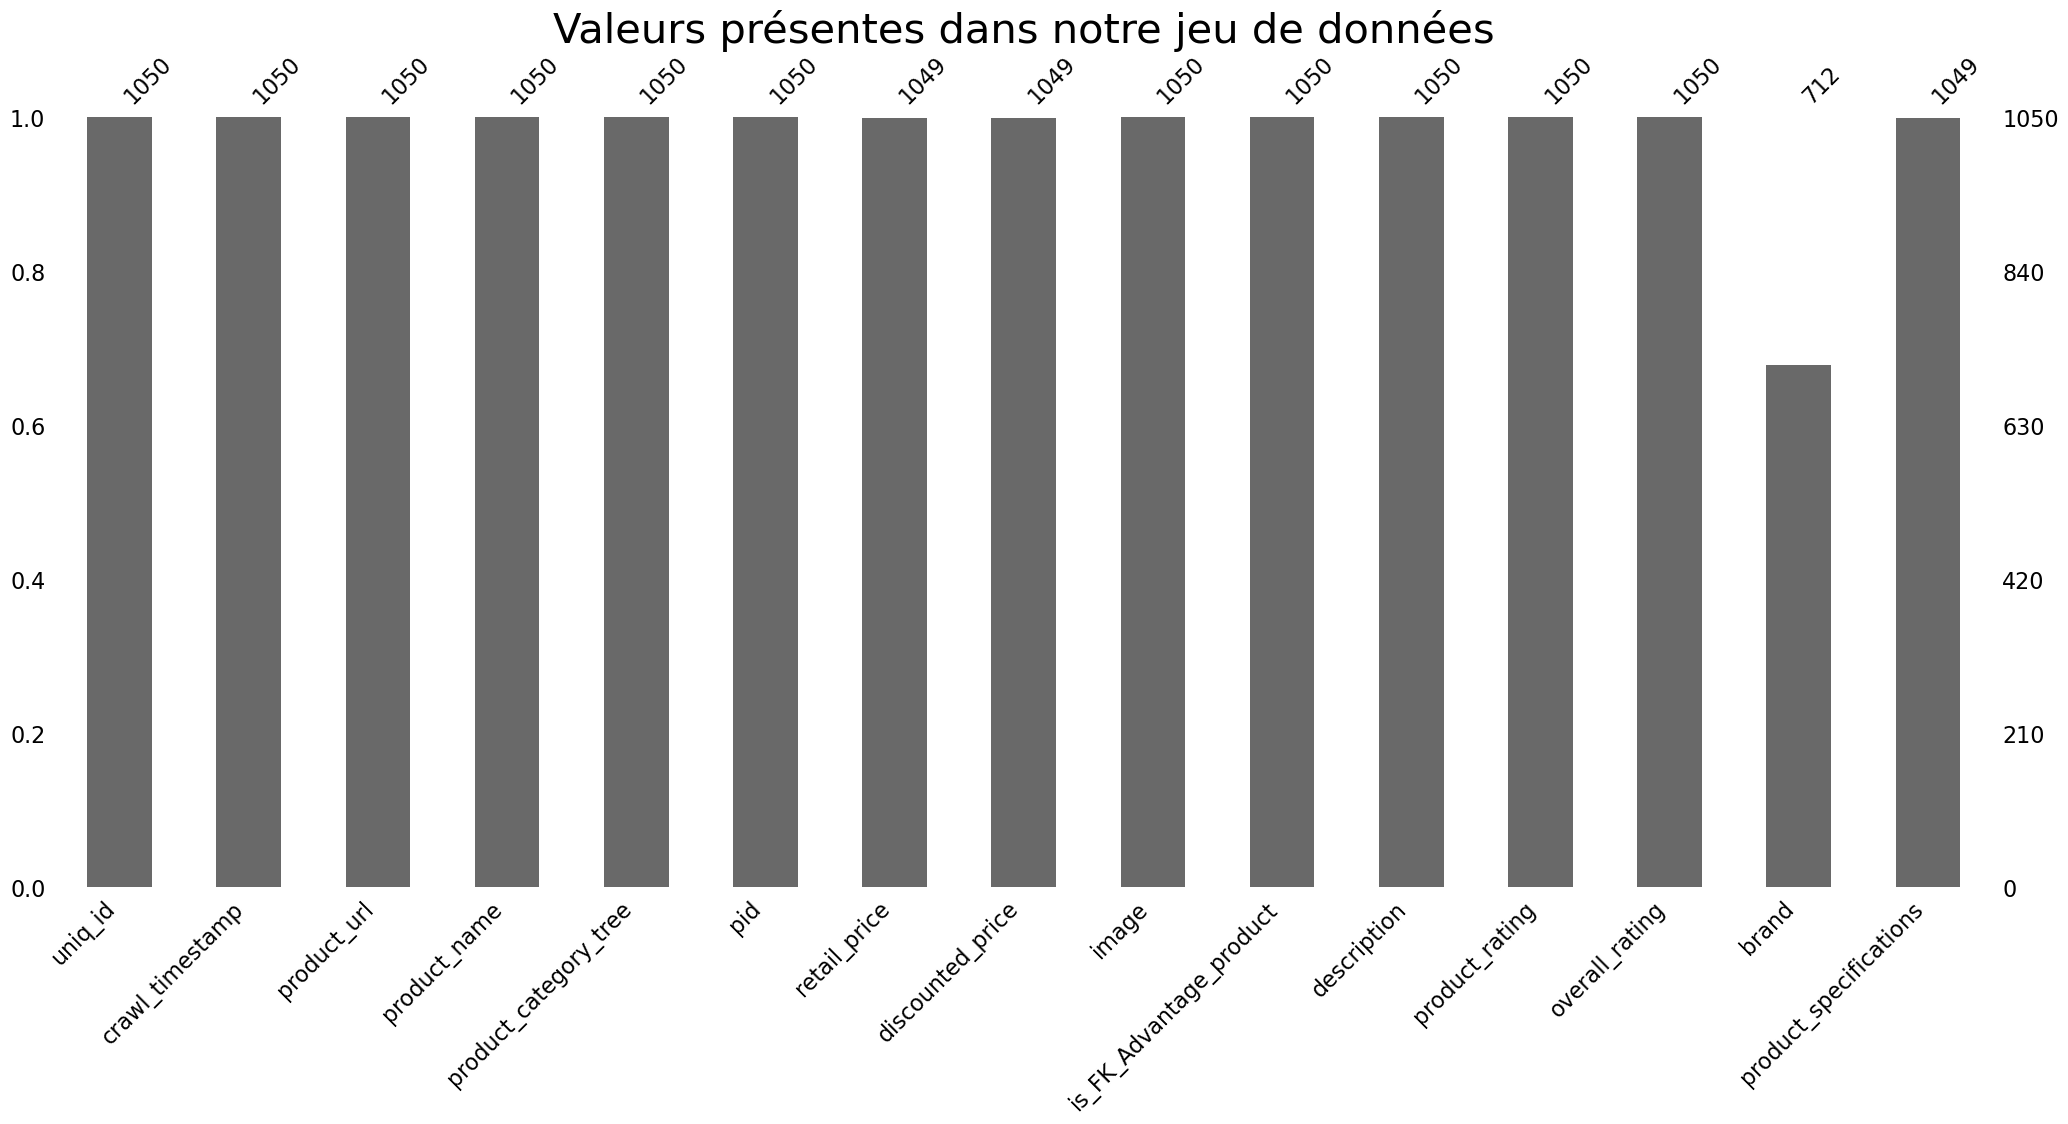

In [16]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(data)

<Axes: >

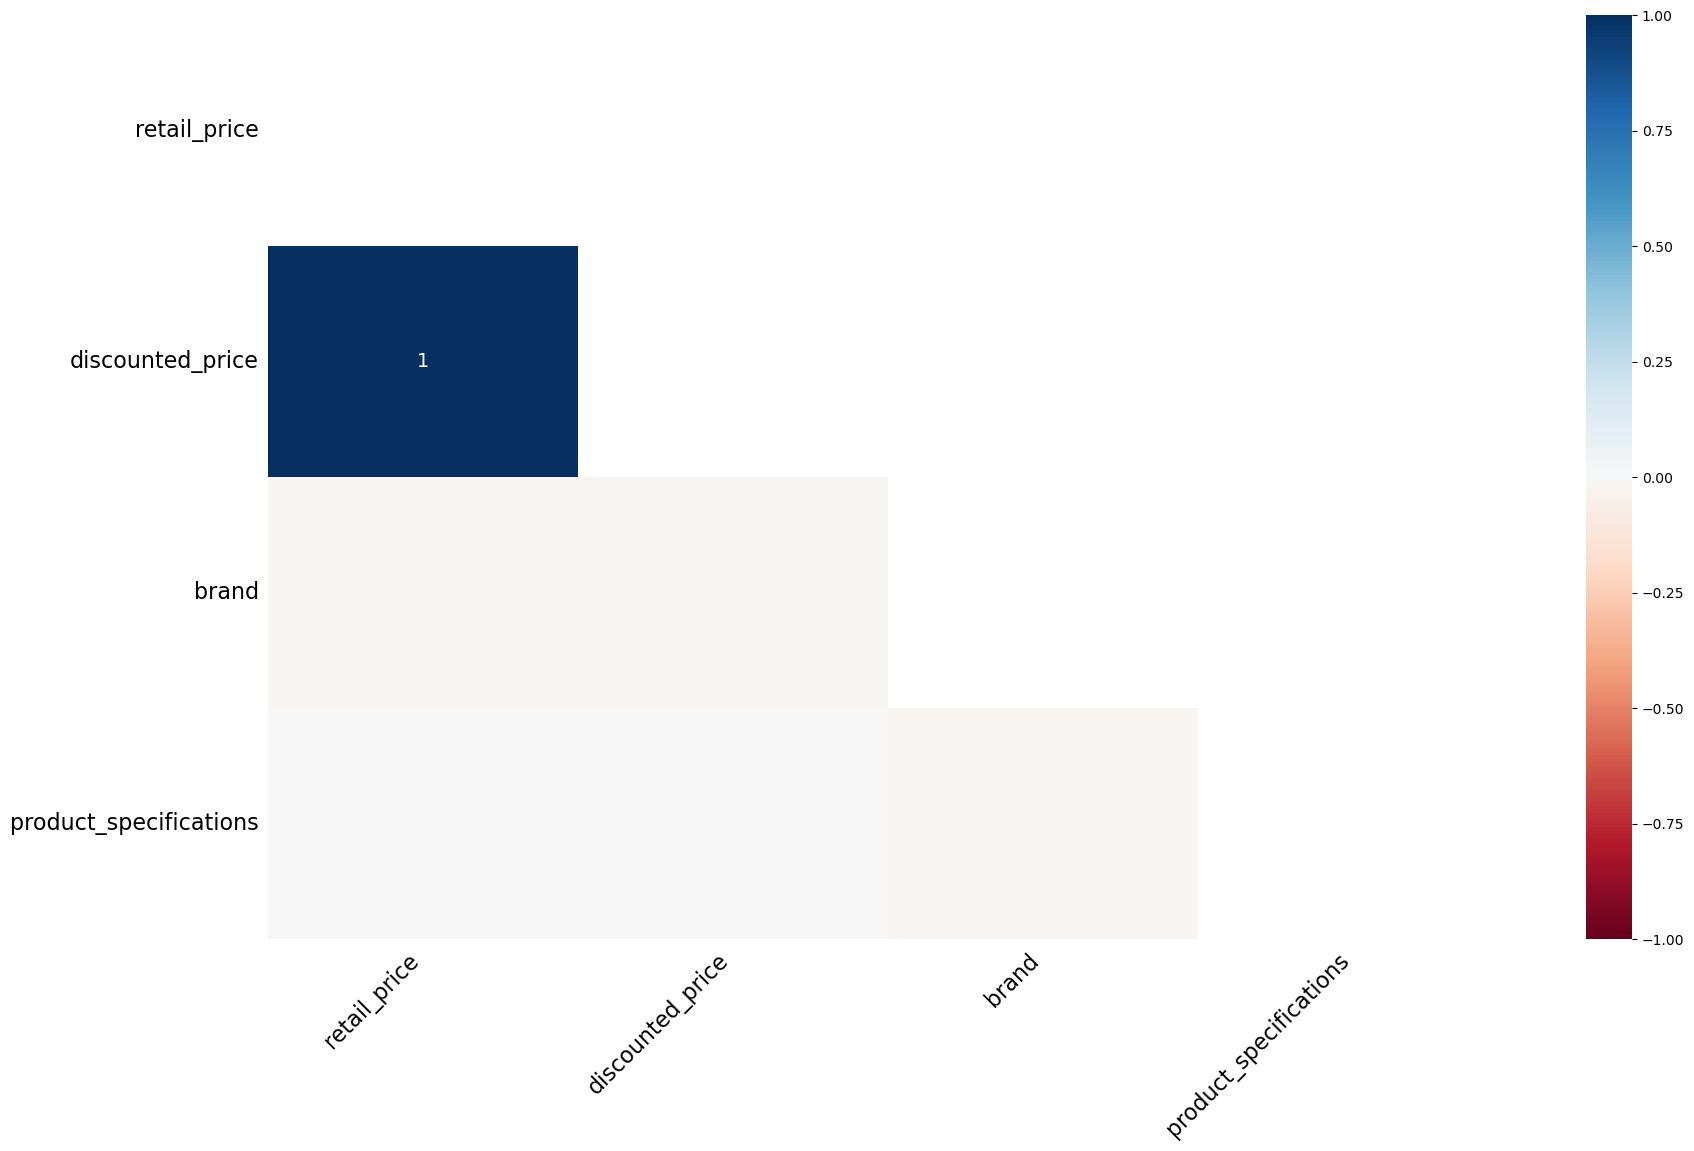

In [17]:
msno.heatmap(data)

## Compréhension des Variables

In [18]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

<b>uniq_id</b> : Un identifiant unique pour chaque entrée de produit.<br>
<b>crawl_timestamp</b> : La date et l'heure de la collecte des données pour chaque produit.<br>
<b>product_url</b> : L'URL directe du produit sur le site de Flipkart.<br>
<b>product_name</b> : Le nom du produit.<br>
<b>product_category_tree</b> : Une chaîne de caractères représentant la catégorie et les sous-catégories du produit dans l'arborescence des catégories de Flipkart.<br>
<b>pid</b> : Un identifiant de produit spécifique à Flipkart.<br>
<b>retail_price</b> : Le prix de vente conseillé du produit.<br>
<b>discounted_price</b> : Le prix remisé du produit.<br>
<b>image</b> : Le nom de fichier de l'image du produit semble être uniq_id.jpg.<br>
<b>is_FK_Advantage_product</b> : Un booléen indiquant si le produit est vendu sous le programme Flipkart Advantage.<br>
<b>description</b> : Une brève description du produit.<br>
<b>product_rating</b> : La note du produit donnée par les utilisateurs<br>
<b>overall_rating</b> : Semblable à product_rating<br>
<b>brand</b> : La marque du produit.<br>
<b>product_specifications</b> : Un champ structuré contenant des spécifications détaillées du produit, telles que la matière, la marque, etc., probablement sous forme d'un dictionnaire ou d'un objet JSON.<br>

In [19]:
# Vérification de la correspondance entre 'image' et 'uniq_id' + '.jpg'
data['check'] = data['image'] == (data['uniq_id'] + '.jpg')

# Vérifier si toutes les lignes respectent cette condition
all_match = data['check'].all()

print(f"Toutes les entrées dans 'image' correspondent à 'uniq_id.jpg' : {all_match}")


Toutes les entrées dans 'image' correspondent à 'uniq_id.jpg' : True


In [20]:
# Liste de toutes les colonnes à conserver
cols_to_keep = ['uniq_id', 'product_category_tree', 'description']

# Pré-traitements des Données

In [21]:
df = data[cols_to_keep]

In [22]:
df.head(5)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [23]:
df.nunique()

uniq_id                  1050
product_category_tree     642
description              1050
dtype: int64

## Récupération des catégories

In [24]:
# Transformation de 'product_category_tree' en 'product_category'
df = df.copy()
df['product_category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip('[" '))
df = df[['uniq_id', 'product_category', 'description']]

df.head(5)

uniq_id product_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [25]:
# Valeurs manquantes
missing_values_count = df.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 0.0 %


In [26]:
print("Valeurs uniques pour product_category dans df:", df['product_category'].unique())

Valeurs uniques pour product_category dans df: ['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


In [27]:
df.product_category.value_counts()

product_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

<Axes: ylabel='count'>

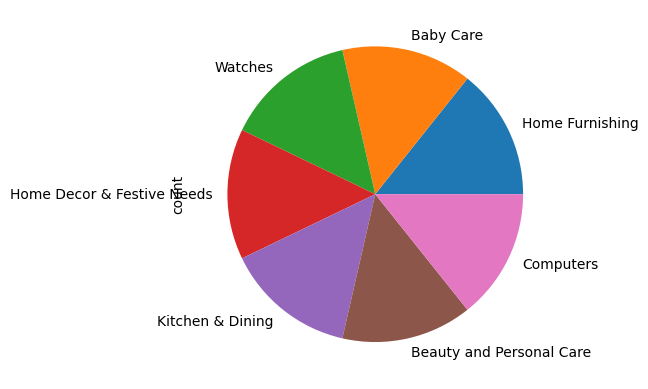

In [28]:
df.product_category.value_counts().plot(kind="pie")

## Taille des descriptions

In [29]:
lengths = df.description.apply(lambda i : len(i))

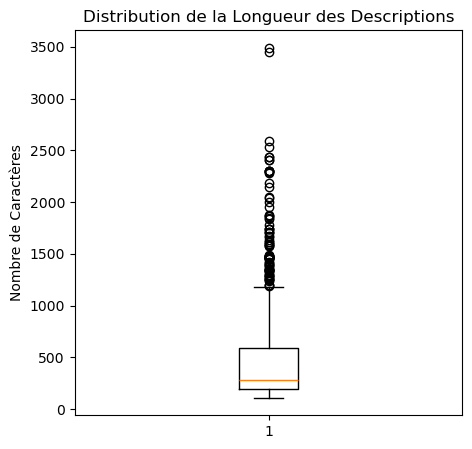

In [30]:
# Création d'un boxplot
plt.figure(figsize=(5, 5))
plt.boxplot(lengths)
plt.title('Distribution de la Longueur des Descriptions')
plt.ylabel('Nombre de Caractères')
plt.show()

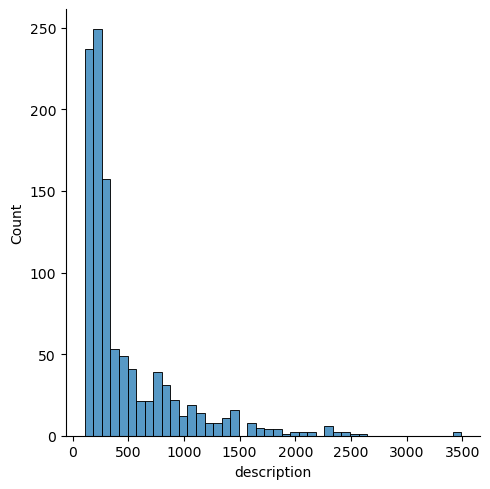

In [31]:
sns.displot(lengths)

In [32]:
df["_len_txt"] = lengths

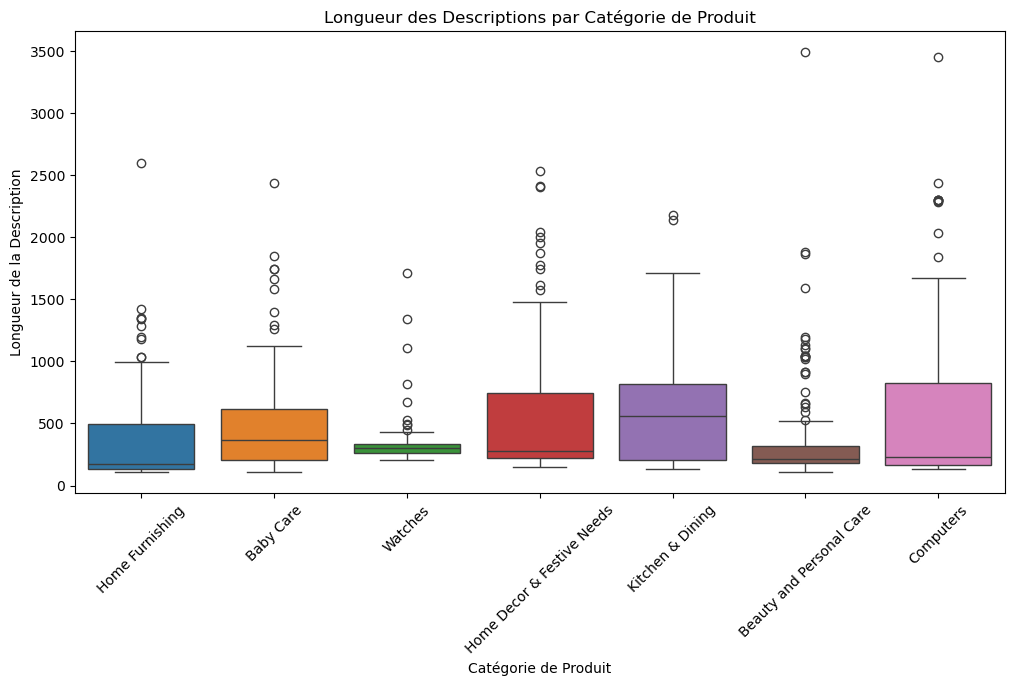

In [33]:
# Boxplot groupé
plt.figure(figsize=(12, 6))
sns.boxplot(x='product_category', y='_len_txt', data=df, palette='tab10', hue='product_category')
plt.xticks(rotation=45)  # Cela aide si les noms des catégories sont longs ou nombreux
plt.title('Longueur des Descriptions par Catégorie de Produit')
plt.xlabel('Catégorie de Produit')
plt.ylabel('Longueur de la Description')
plt.show()

## Doublons

In [34]:
df.duplicated().sum()

0

In [35]:
df.duplicated(subset='description').sum()

0

## Sur un document

In [36]:
doc = df.description.sample(1)
doc = doc.values[0]
doc

'Skmei DG0939-Red Sports Digital Watch  - For Men, Boys - Buy Skmei DG0939-Red Sports Digital Watch  - For Men, Boys  DG0939-Red Online at Rs.999 in India Only at Flipkart.com. Digital Chronograph, Alarm Watch, Light Function, Date & Month Display - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

### Nettoyage des descriptions

In [37]:
cleaned_text = process_text(doc, clean=True)
print(cleaned_text)

skmei dgred sports digital watch   for men boys  buy skmei dgred sports digital watch   for men boys  dgred online at rs in india only at flipkartcom digital chronograph alarm watch light function date  month display  great discounts only genuine products  day replacement guarantee free shipping cash on delivery


### Tokenisation

Test de différent tokenizer

In [38]:
def display_tokens_info(tokens):
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

#### Word_tokenize

In [39]:
tokens = process_text(doc, clean=True, tokenize_method='word_tokenize')
display_tokens_info(tokens)

nb tokens 48, nb tokens uniques 35
['skmei', 'dgred', 'sports', 'digital', 'watch', 'for', 'men', 'boys', 'buy', 'skmei', 'dgred', 'sports', 'digital', 'watch', 'for', 'men', 'boys', 'dgred', 'online', 'at', 'rs', 'in', 'india', 'only', 'at', 'flipkartcom', 'digital', 'chronograph', 'alarm', 'watch']


#### Wordpunct_tokenize

In [40]:
tokens = process_text(doc, clean=True, tokenize_method='wordpunct')
display_tokens_info(tokens)

nb tokens 48, nb tokens uniques 35
['skmei', 'dgred', 'sports', 'digital', 'watch', 'for', 'men', 'boys', 'buy', 'skmei', 'dgred', 'sports', 'digital', 'watch', 'for', 'men', 'boys', 'dgred', 'online', 'at', 'rs', 'in', 'india', 'only', 'at', 'flipkartcom', 'digital', 'chronograph', 'alarm', 'watch']


#### Regex Tokenize

In [41]:
tokens = process_text(doc, clean=True, tokenize_method='regex')
display_tokens_info(tokens)

nb tokens 48, nb tokens uniques 35
['skmei', 'dgred', 'sports', 'digital', 'watch', 'for', 'men', 'boys', 'buy', 'skmei', 'dgred', 'sports', 'digital', 'watch', 'for', 'men', 'boys', 'dgred', 'online', 'at', 'rs', 'in', 'india', 'only', 'at', 'flipkartcom', 'digital', 'chronograph', 'alarm', 'watch']


=> Résultats équivalents

### Suppression des Stop words

In [42]:
cleaned_text = process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True)
print(cleaned_text)

['skmei', 'dgred', 'sports', 'digital', 'watch', 'men', 'boys', 'buy', 'skmei', 'dgred', 'sports', 'digital', 'watch', 'men', 'boys', 'dgred', 'online', 'rs', 'india', 'flipkartcom', 'digital', 'chronograph', 'alarm', 'watch', 'light', 'function', 'date', 'month', 'display', 'great', 'discounts', 'genuine', 'products', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'delivery']


### Stemming

In [43]:
cleaned_text = process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True, stemming=True, lemmatization=False)
print(cleaned_text)

['skmei', 'dgred', 'sport', 'digit', 'watch', 'men', 'boy', 'buy', 'skmei', 'dgred', 'sport', 'digit', 'watch', 'men', 'boy', 'dgred', 'onlin', 'rs', 'india', 'flipkartcom', 'digit', 'chronograph', 'alarm', 'watch', 'light', 'function', 'date', 'month', 'display', 'great', 'discount', 'genuin', 'product', 'day', 'replac', 'guarante', 'free', 'ship', 'cash', 'deliveri']


### Lemmatization

In [44]:
cleaned_text = process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True, stemming=False, lemmatization=True)
print(cleaned_text)

['skmei', 'dgred', 'sport', 'digital', 'watch', 'men', 'boy', 'buy', 'skmei', 'dgred', 'sport', 'digital', 'watch', 'men', 'boy', 'dgred', 'online', 'r', 'india', 'flipkartcom', 'digital', 'chronograph', 'alarm', 'watch', 'light', 'function', 'date', 'month', 'display', 'great', 'discount', 'genuine', 'product', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'delivery']


=> A première vue, la lemmatization favorisera une meilleure distinction sémantique entre les catégories.

## Sur le corpus

### Suppression des mots uniques

In [45]:
# Aplatir la liste de listes en une seule liste de tokens
all_tokens = [token for sublist in df['description'] for token in sublist]

corpus = "".join(all_tokens)

In [46]:
corpus[:1000]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [47]:
len(corpus)

497512

In [48]:
processed_corpus = process_text(corpus, clean=True, tokenize_method='word_tokenize',
                                    remove_stopwords=True, stemming=False,
                                    lemmatization=True)
display_tokens_info(processed_corpus)

nb tokens 54277, nb tokens uniques 5513
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtainelegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', 'high', 'quality']


In [49]:
# Calculer la distribution de fréquence des tokens
freq_dist = FreqDist(processed_corpus)

In [50]:
# Liste des mots avec une fréquence de 1
hapaxes = freq_dist.hapaxes()

# Affichage de la liste des hapaxes
print(hapaxes[:20])

['curtainelegance', 'interiorsthis', 'fabricit', 'ringit', 'romantic', 'lovingthis', 'wrinkle', 'apparancegive', 'modernistic', 'surreal', 'steal', 'valance', 'close', 'joyous', 'softly', 'filter', 'sunlightspecifications', 'duster', 'asvtwl', 'mediam']


In [51]:
# Appel de la fonction 'process_text' avec la suppression des mots avec une frequence de 1
processed_corpus = process_text(corpus, clean=True, tokenize_method='word_tokenize', 
                              remove_stopwords=True, stemming=False, 
                              lemmatization=True, words_to_remove=hapaxes)

display_tokens_info(processed_corpus)

nb tokens 52220, nb tokens uniques 3456
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'curtain', 'enhances', 'look', 'curtain', 'made', 'high', 'quality', 'polyester', 'feature']


# Exploratory Data Analysis

## Global

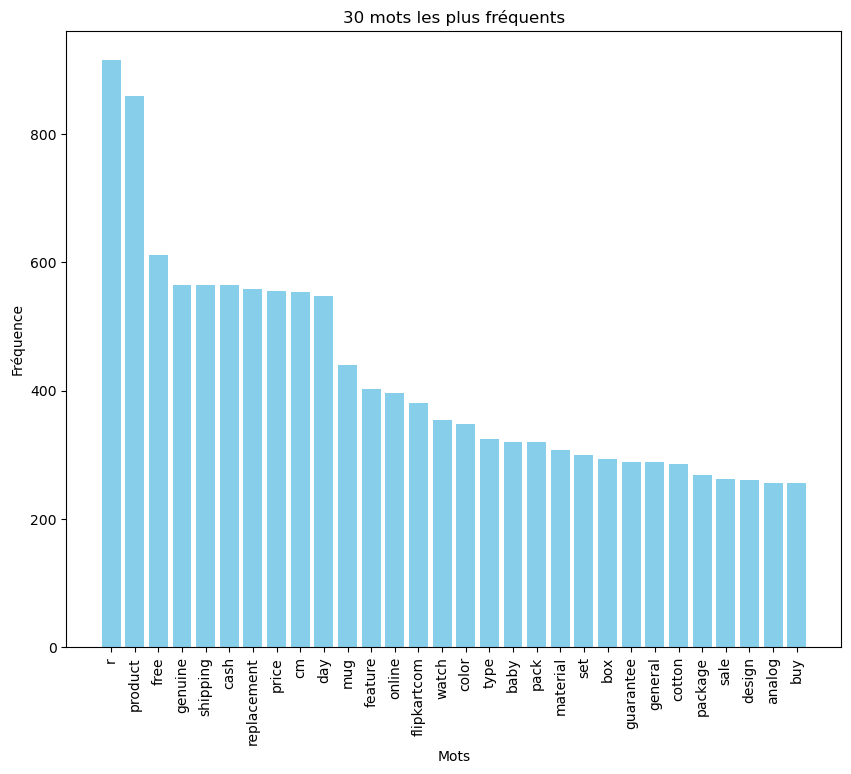

In [52]:
# Calculer la distribution de fréquence des tokens
freq_dist = FreqDist(processed_corpus)

# 30 mots les plus fréquents
common_words = freq_dist.most_common(30)

# Séparation des mots et de leurs fréquences
words, frequencies = zip(*common_words)

# Création du graphique
plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=90)
plt.title('30 mots les plus fréquents')
plt.show()

In [53]:
common_words

[('r', 915),
 ('product', 860),
 ('free', 611),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('price', 555),
 ('cm', 554),
 ('day', 547),
 ('mug', 440),
 ('feature', 403),
 ('online', 396),
 ('flipkartcom', 380),
 ('watch', 354),
 ('color', 347),
 ('type', 324),
 ('baby', 320),
 ('pack', 319),
 ('material', 307),
 ('set', 300),
 ('box', 293),
 ('guarantee', 289),
 ('general', 288),
 ('cotton', 285),
 ('package', 268),
 ('sale', 262),
 ('design', 260),
 ('analog', 255),
 ('buy', 255)]

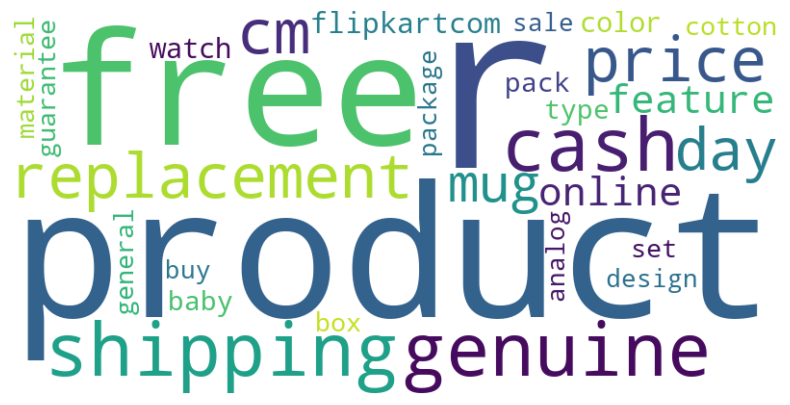

In [54]:
# Création d'un nuage de mots
common_words_dict = dict(common_words)

# Création d'un nuage de mots à partir des fréquences
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate_from_frequencies(common_words_dict)

# Affichage du nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Par catégories

Pour la catégorie Baby Care
nb tokens 8194, nb tokens uniques 1066
['specification', 'sathiyas', 'cotton', 'bath', 'towel', 'bath', 'towel', 'red', 'yellow', 'blue', 'bath', 'towel', 'feature', 'machine', 'washable', 'yes', 'material', 'cotton', 'design', 'self', 'design', 'general', 'brand', 'sathiyas', 'type', 'bath', 'towel', 'gsm', 'model', 'name']


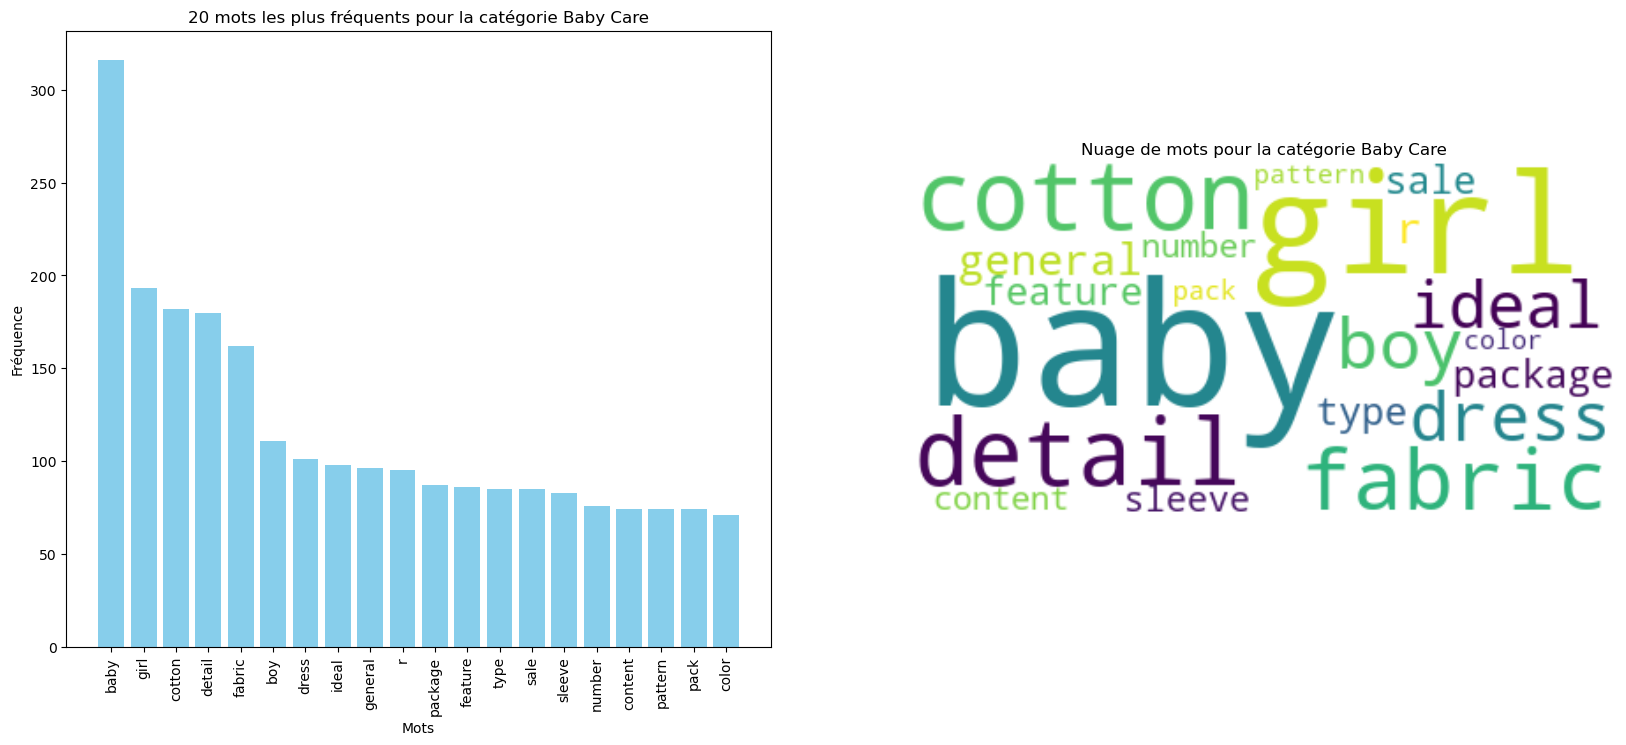

Pour la catégorie Beauty and Personal Care
nb tokens 5772, nb tokens uniques 956
['key', 'feature', 'burt', 'bee', 'hair', 'repair', 'shea', 'grapefruit', 'deep', 'conditioner', 'ideal', 'boy', 'girl', 'applied', 'deep', 'conditioning', 'hair', 'condition', 'damaged', 'hair', 'hair', 'type', 'dry', 'hairspecifications', 'burt', 'bee', 'hair', 'repair', 'shea', 'grapefruit']


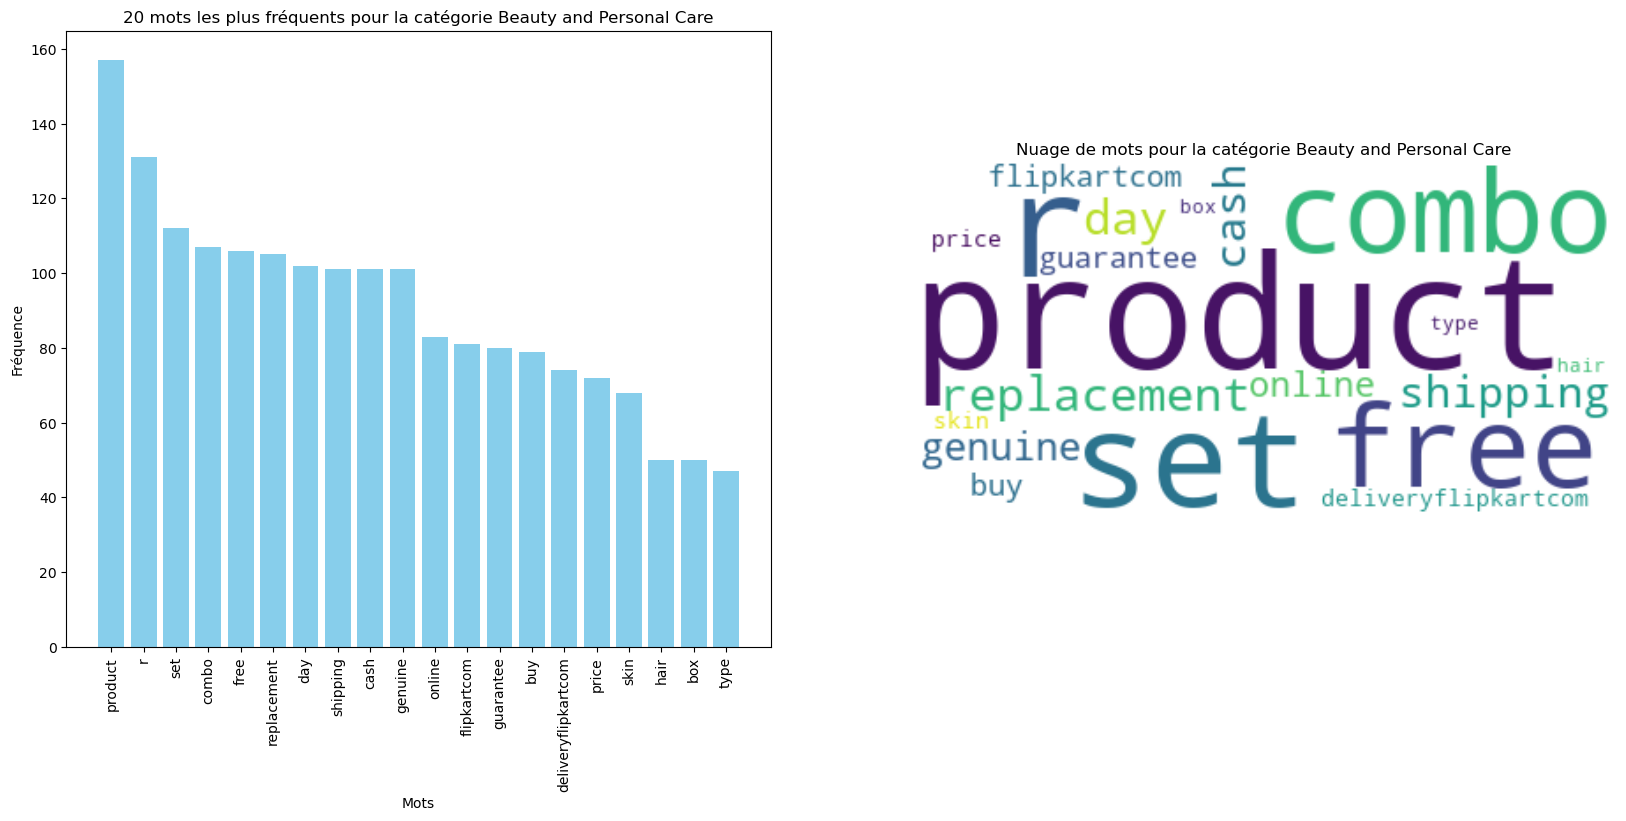

Pour la catégorie Computers
nb tokens 8709, nb tokens uniques 932
['key', 'feature', 'dlink', 'dap', 'dlink', 'dap', 'white', 'speed', 'wireless', 'speed', 'mbps', 'modem', 'speed', 'mbps', 'general', 'brand', 'dlink', 'box', 'extender', 'plug', 'model', 'dap', 'type', 'range', 'color', 'white', 'warranty', 'covered', 'warranty', 'damage']


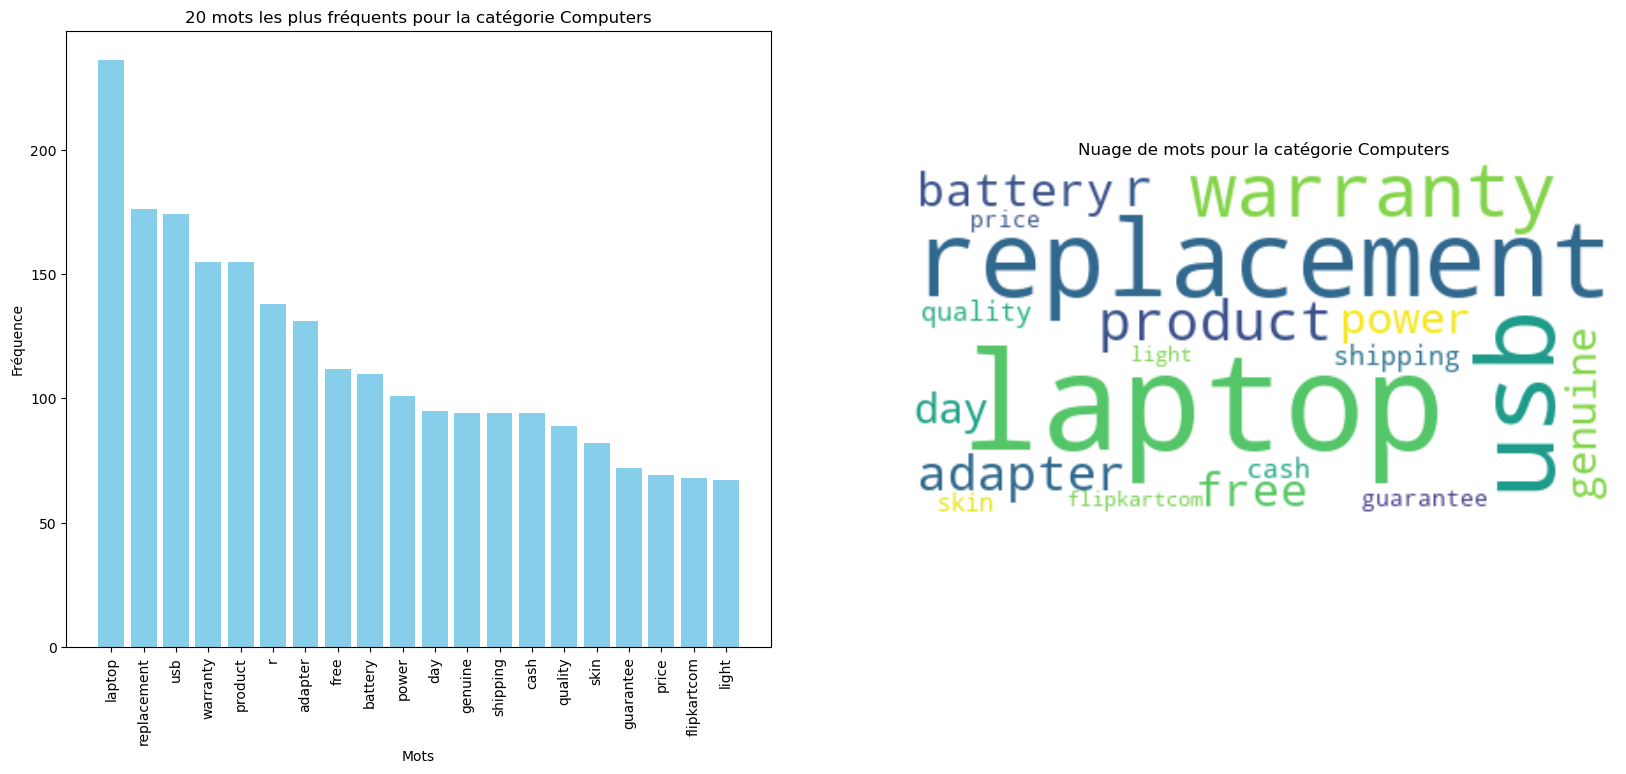

Pour la catégorie Home Decor & Festive Needs
nb tokens 8662, nb tokens uniques 1317
['myesquire', 'ceramic', 'burner', 'pot', 'lemongrass', 'liquid', 'air', 'ml', 'price', 'r', 'illuminate', 'every', 'corner', 'living', 'room', 'style', 'home', 'fragrance', 'electric', 'burner', 'combo', 'fragrance', 'brought', 'myesquire', 'unique', 'useful', 'value', 'money', 'product', 'home']


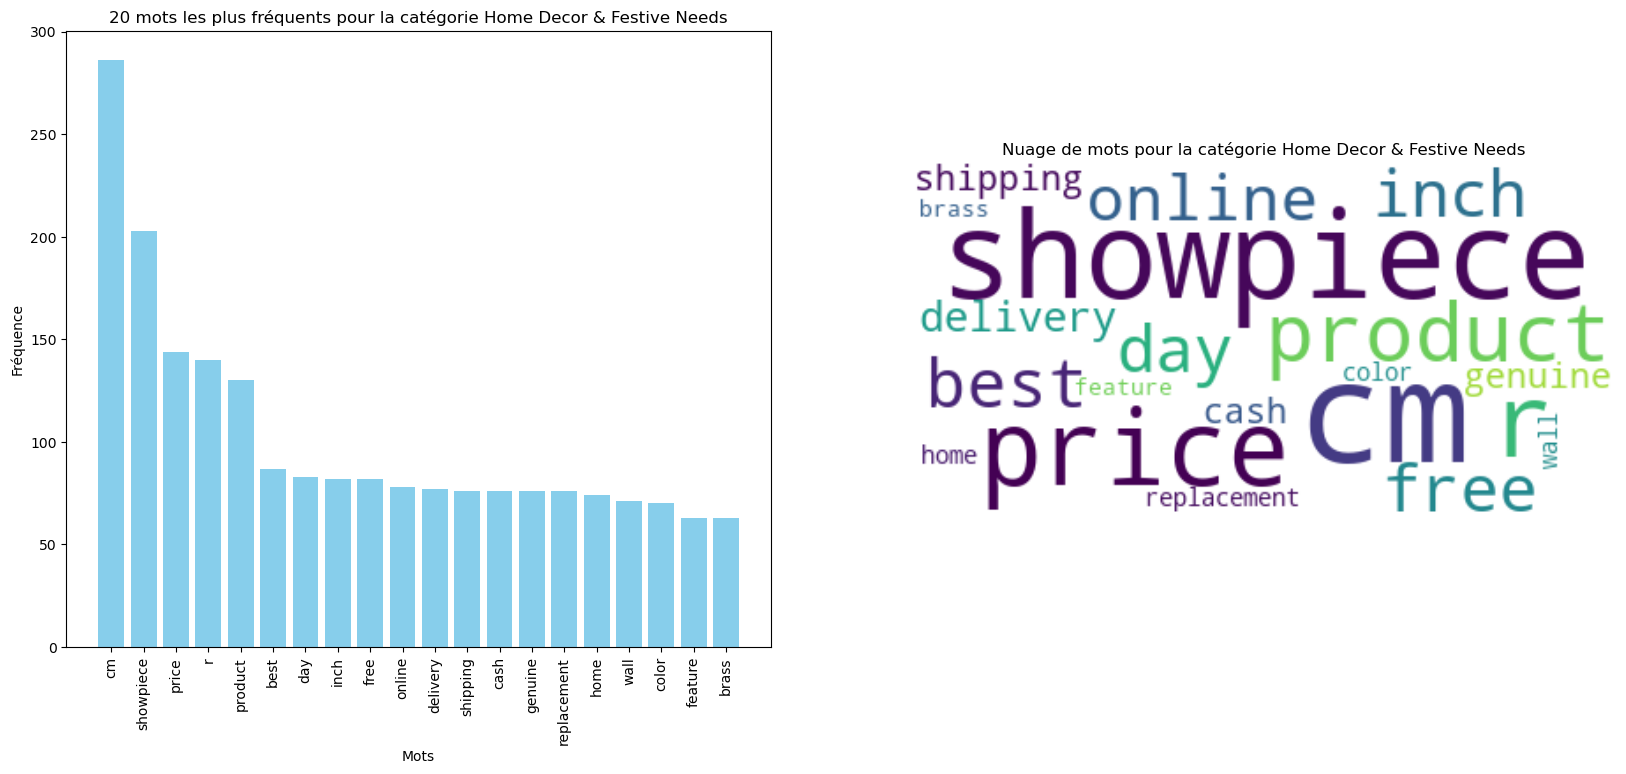

Pour la catégorie Home Furnishing
nb tokens 6112, nb tokens uniques 743
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'curtain', 'enhances', 'look', 'curtain', 'made', 'high', 'quality', 'polyester', 'feature']


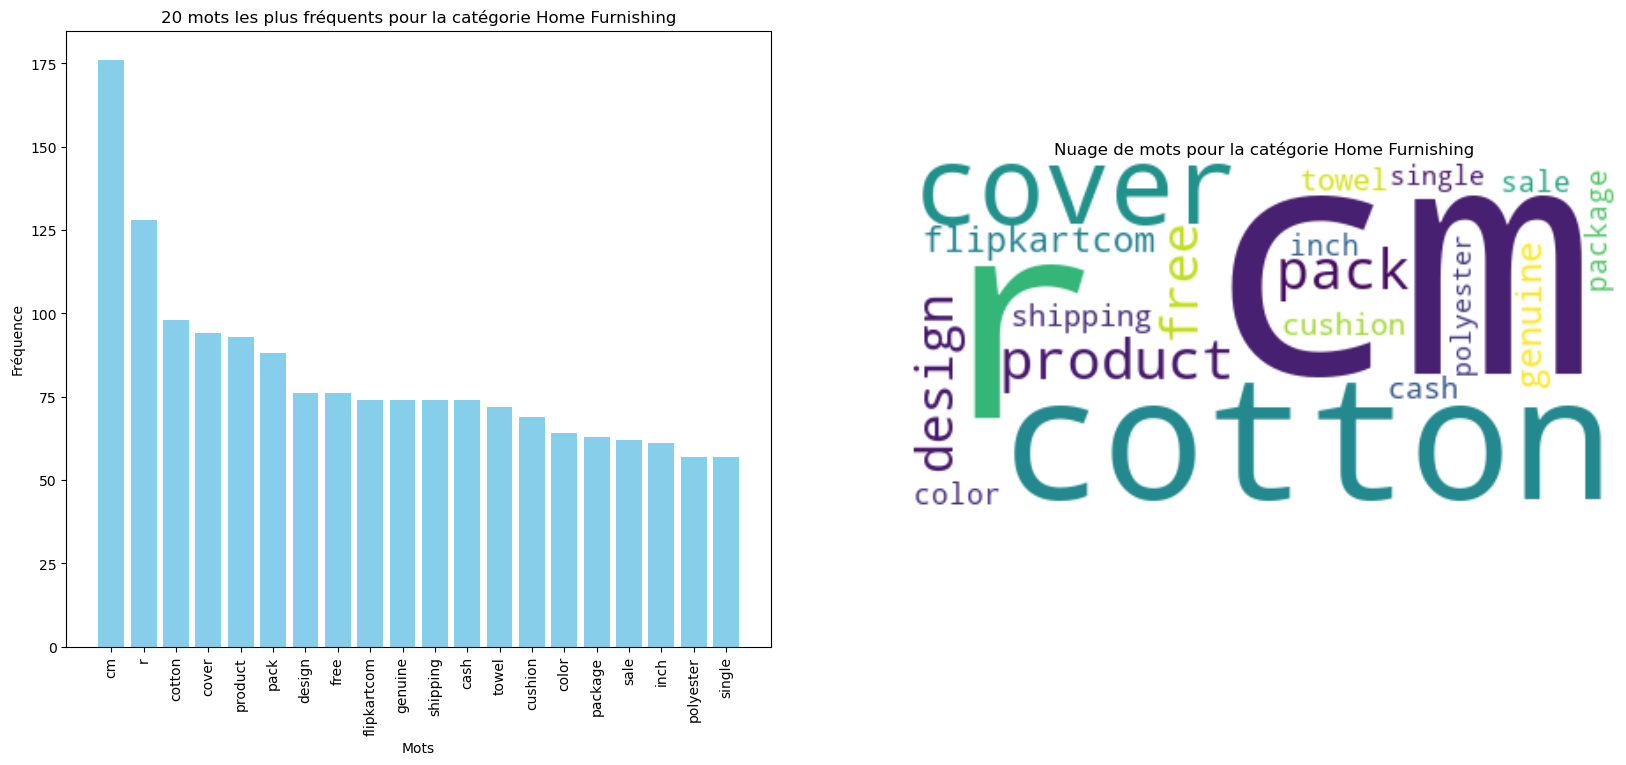

Pour la catégorie Kitchen & Dining
nb tokens 9691, nb tokens uniques 1011
['key', 'feature', 'dungri', 'india', 'craft', 'ducjugducgl', 'jug', 'glass', 'set', 'jug', 'height', 'inch', 'dia', 'inch', 'depth', 'inch', 'width', 'ml', 'weight', 'india', 'craft', 'ducjugducgl', 'jug', 'glass', 'set', 'copper', 'price', 'r', 'copper', 'utensil']


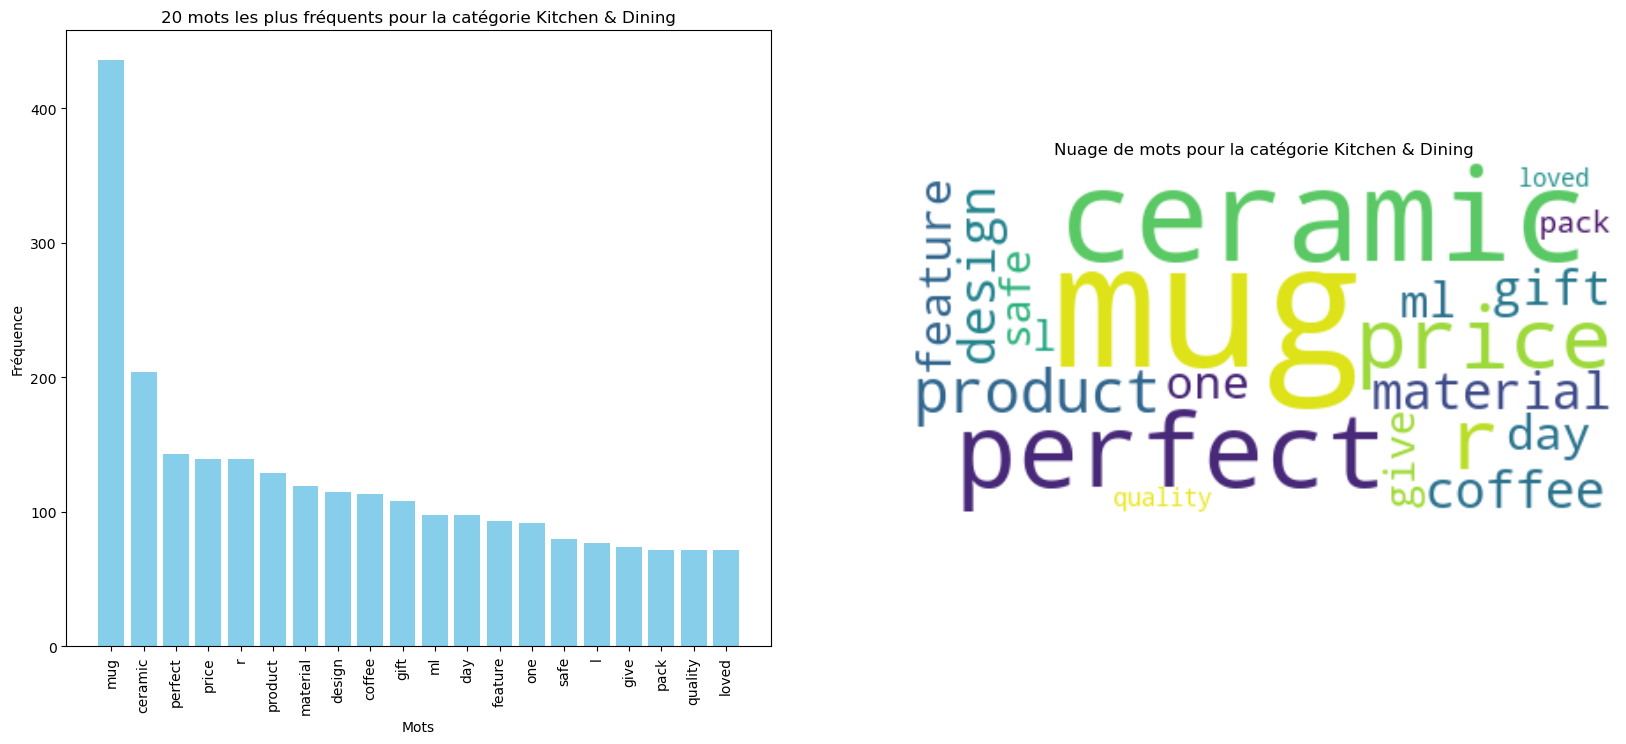

Pour la catégorie Watches
nb tokens 5180, nb tokens uniques 493
['time', 'r', 'analog', 'watch', 'boy', 'buy', 'time', 'r', 'analog', 'watch', 'boy', 'r', 'online', 'r', 'india', 'flipkartcom', 'great', 'discount', 'genuine', 'product', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'wm', 'elegance', 'analog', 'watch']


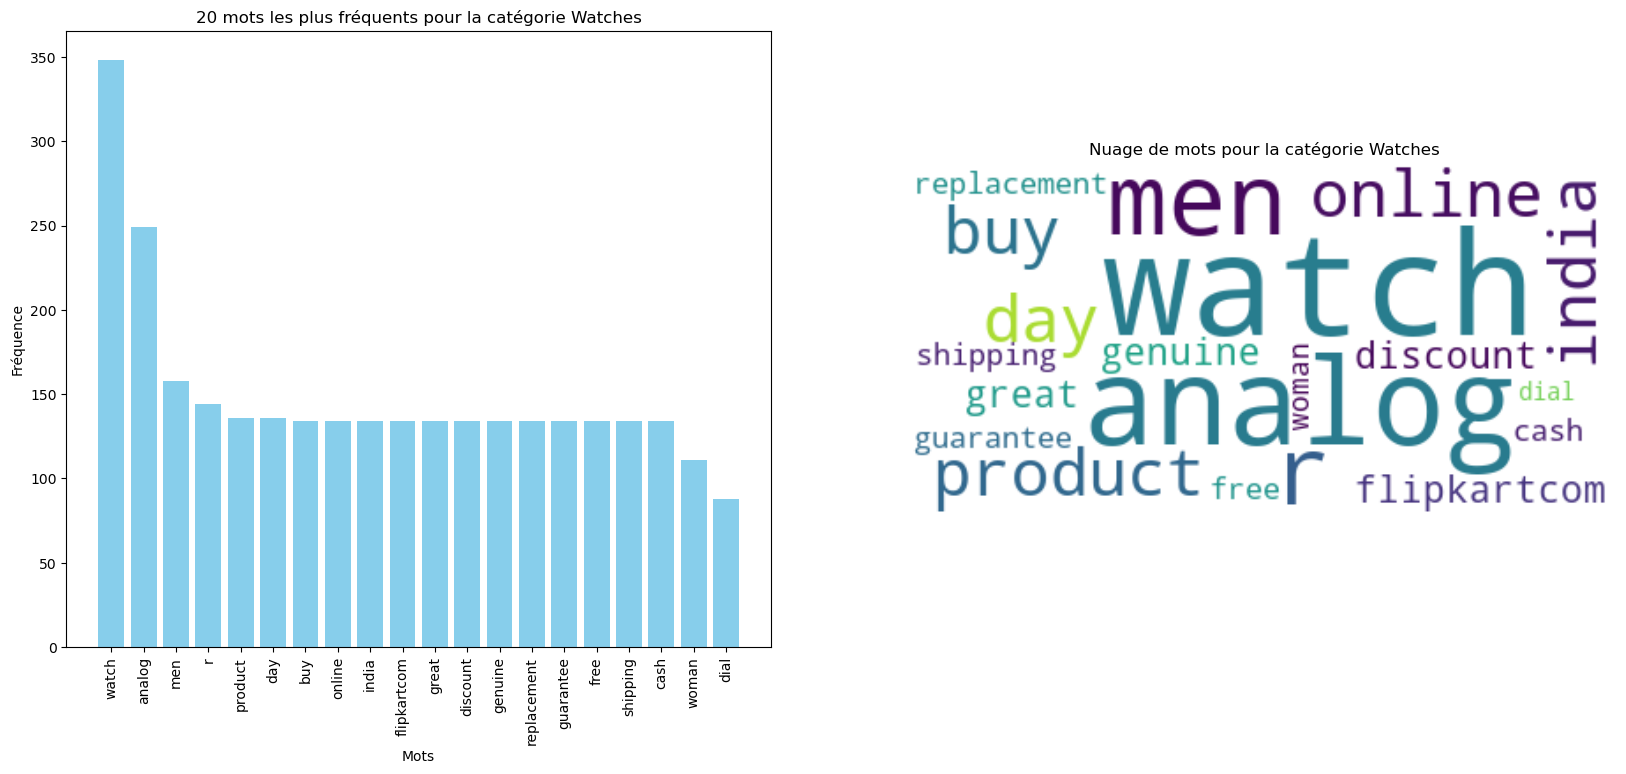

In [55]:
# Itérer sur chaque catégorie de produit
for category, group in df.groupby('product_category'):
    # Aplatir la liste de listes en une seule liste de tokens pour la catégorie actuelle
    all_tokens = [token for sublist in group['description'] for token in sublist]
    cat_corpus = "".join(all_tokens)

    # Traiter des données
    processed_cat_corpus = process_text(cat_corpus, clean=True, tokenize_method='word_tokenize',
                                        remove_stopwords=True, stemming=False,
                                        lemmatization=True, words_to_remove=hapaxes)
    print(f'Pour la catégorie {category}')
    display_tokens_info(processed_cat_corpus)
    
    # Calculer la distribution de fréquence des tokens pour la catégorie
    freq_dist = FreqDist(processed_cat_corpus)
    
    # 20 mots les plus fréquents pour la catégorie
    common_words = freq_dist.most_common(20)
    
    # Séparation des mots et de leurs fréquences
    words, frequencies = zip(*common_words)
    
    # Préparation des subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    # Histogramme
    ax[0].bar(range(len(words)), frequencies, color='skyblue')
    ax[0].set_xlabel('Mots')
    ax[0].set_ylabel('Fréquence')
    ax[0].set_xticks(range(len(words)))
    ax[0].set_xticklabels(words, rotation=90)
    ax[0].set_title(f'20 mots les plus fréquents pour la catégorie {category}')
    
    # Création d'un nuage de mots pour la catégorie
    common_words_dict = dict(common_words)
    wordcloud = WordCloud(width=400, height=200, background_color='white',
                          min_font_size=10).generate_from_frequencies(common_words_dict)
    
    # Affichage du nuage de mots
    ax[1].imshow(wordcloud, interpolation="bilinear")
    ax[1].axis('off')
    ax[1].set_title(f'Nuage de mots pour la catégorie {category}')
    
    plt.show()

# Transformation des données

In [56]:
# Traitement de chaque document avec process_text et stockage des résultats dans une nouvelle liste
processed_docs = [process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True,
                               stemming=False, lemmatization=True, words_to_remove=hapaxes) for doc in df['description']]

preprocessed_texts = [" ".join(doc) for doc in processed_docs]

In [57]:
preprocessed_texts[:3]

['key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look curtain made high quality polyester feature eyelet style stitch metal make room environment curtain ant anti shrinkage elegant home bright appeal design attention sure heart contemporary eyelet curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw evening create special moment beauty given soothing print bring home elegant curtain light room get right amount elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id color multicolor dimension length cm box number content sale package pack sale package curtain body design material polyester',
 'specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machi

## Seuils de fréquences

In [58]:
# Calcul de la fréquence documentaire pour chaque mot
word_doc_freq = {}
for tokens in processed_docs:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        word_doc_freq[token] = word_doc_freq.get(token, 0) + 1

# Seuils de fréquence documentaire
min_threshold = 0.002 * len(processed_docs)
max_threshold = 0.7 * len(processed_docs)

# Identification des mots en dehors des seuils
high_freq_words = [word for word, freq in word_doc_freq.items() if freq > max_threshold]
low_freq_words = [word for word, freq in word_doc_freq.items() if freq < min_threshold]

print("Mots avec une fréquence documentaire supérieure à 0.7 :", high_freq_words)
print("Mots avec une fréquence documentaire inférieur à 0.002 :", low_freq_words[:20])

Mots avec une fréquence documentaire supérieure à 0.7 : ['r']
Mots avec une fréquence documentaire inférieur à 0.002 : ['welcome', 'given', 'apart', 'stitch', 'slide', 'shrinkage', 'sathiyas', 'feeling', 'exporting', 'softness', 'absorbency', 'eurospa', 'shuvampcftsetassorted', 'santosh', 'gifted', 'origional', 'returne', 'waranty', 'machinewash', 'wm']


In [59]:
# Vérifiez le seuil calculé
print("Seuil (min_threshold) :", min_threshold)
print("Seuil (max_threshold) :", max_threshold)

Seuil (min_threshold) : 2.1
Seuil (max_threshold) : 735.0


In [60]:
# Concaténation des listes
combined_list = hapaxes + high_freq_words + low_freq_words

In [61]:
# Traitement de chaque document avec process_text et stockage des résultats dans une nouvelle liste
processed_docs = [process_text(doc, clean=True, tokenize_method='word_tokenize', remove_stopwords=True,
                               stemming=False, lemmatization=True, words_to_remove=combined_list) for doc in df['description']]

preprocessed_texts = [" ".join(doc) for doc in processed_docs]

<b>Effets de l'appplication des seuils sur les nuages de mots par catégories</b>

Pour la catégorie Baby Care
nb tokens 7356, nb tokens uniques 737
['specification', 'cotton', 'bath', 'towel', 'bath', 'towel', 'red', 'yellow', 'blue', 'bath', 'towel', 'feature', 'machine', 'washable', 'yes', 'material', 'cotton', 'design', 'self', 'design', 'general', 'brand', 'type', 'bath', 'towel', 'gsm', 'model', 'name', 'cotton', 'bath']


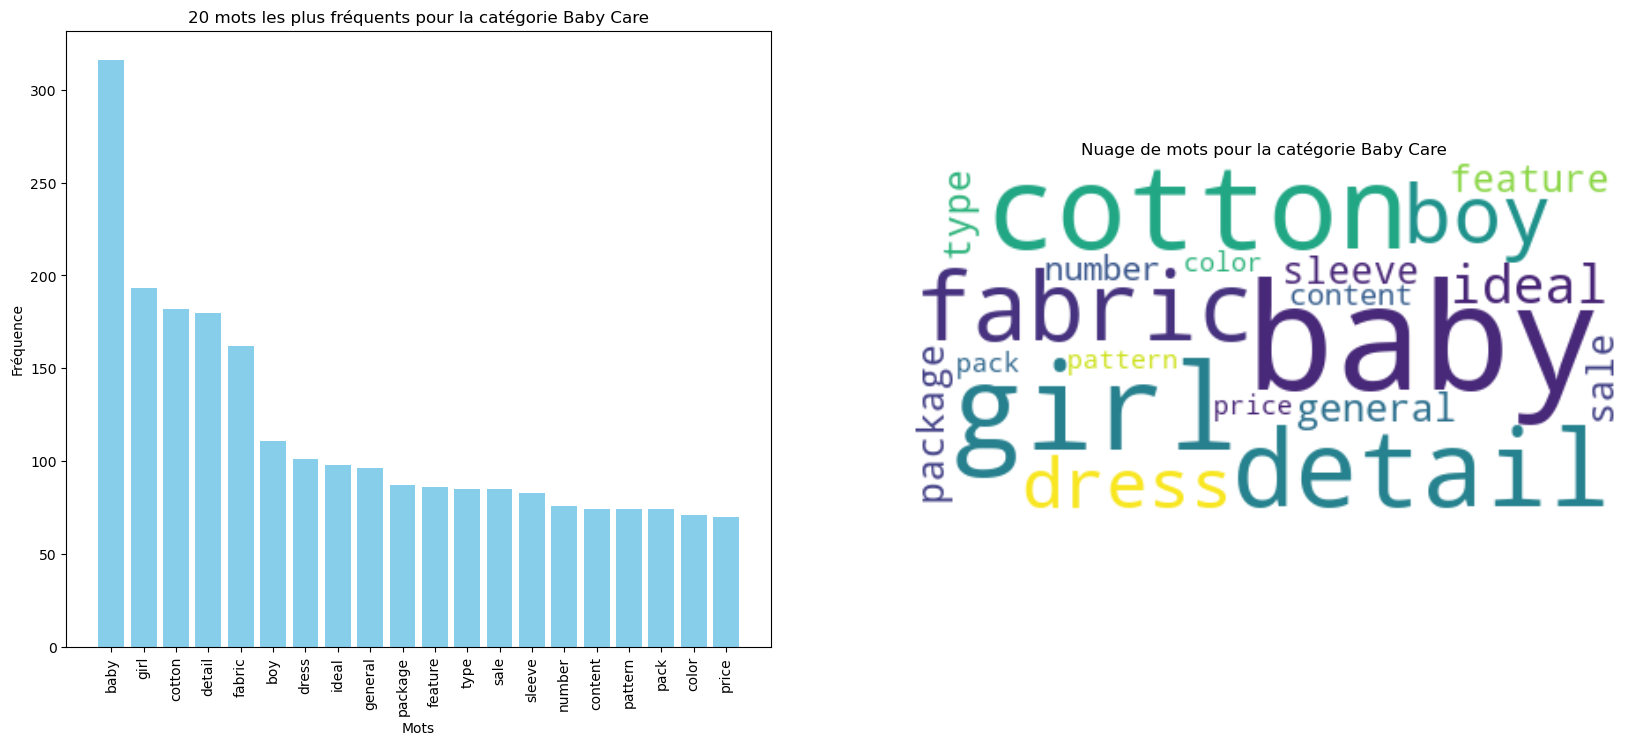

Pour la catégorie Beauty and Personal Care
nb tokens 4851, nb tokens uniques 634
['key', 'feature', 'hair', 'repair', 'deep', 'conditioner', 'ideal', 'boy', 'girl', 'applied', 'deep', 'hair', 'condition', 'damaged', 'hair', 'hair', 'type', 'dry', 'hair', 'repair', 'deep', 'conditioner', 'ml', 'conditioner', 'trait', 'hair', 'condition', 'damaged', 'hair', 'hair']


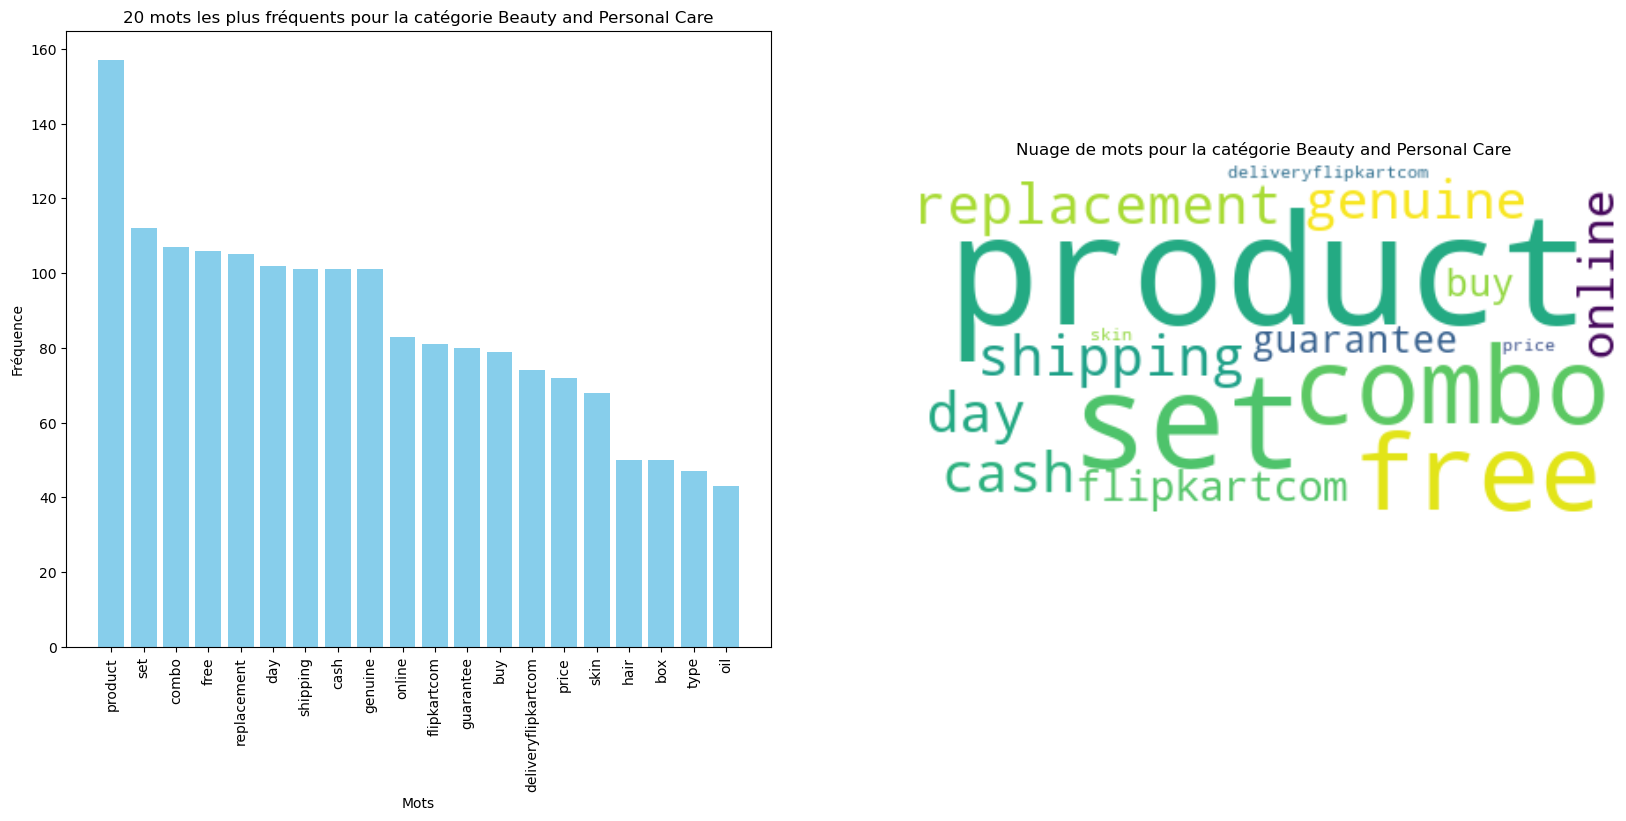

Pour la catégorie Computers
nb tokens 7711, nb tokens uniques 620
['key', 'feature', 'dlink', 'dlink', 'white', 'speed', 'wireless', 'speed', 'mbps', 'modem', 'speed', 'mbps', 'general', 'brand', 'dlink', 'box', 'extender', 'plug', 'model', 'type', 'range', 'color', 'white', 'warranty', 'covered', 'warranty', 'damage', 'warranty', 'summary', 'year']


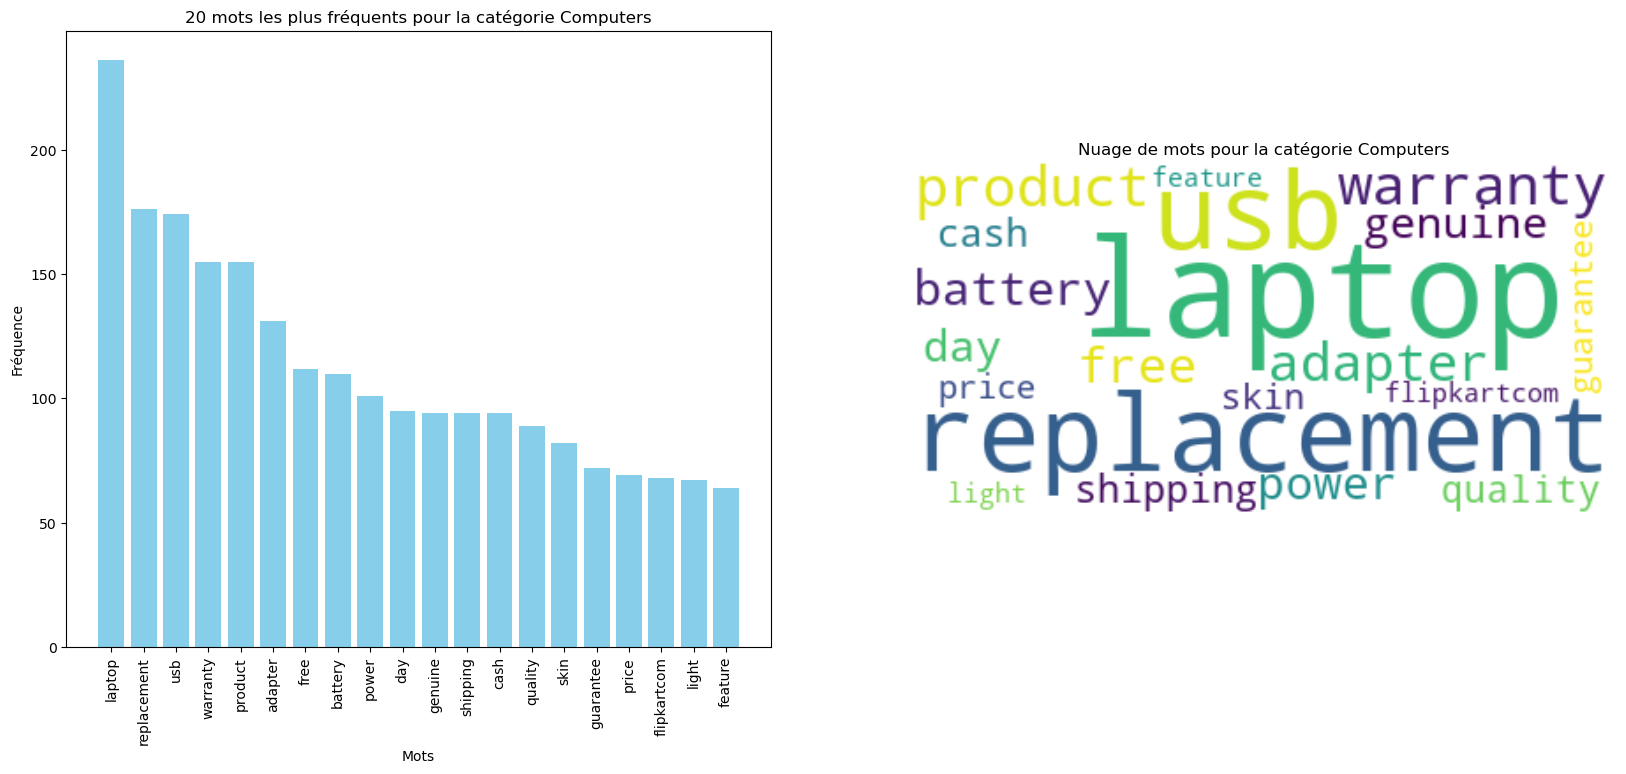

Pour la catégorie Home Decor & Festive Needs
nb tokens 7285, nb tokens uniques 819
['ceramic', 'pot', 'liquid', 'air', 'ml', 'price', 'every', 'corner', 'living', 'room', 'style', 'home', 'fragrance', 'combo', 'fragrance', 'unique', 'useful', 'product', 'home', 'decoration', 'fragrance', 'unique', 'combo', 'contains', 'aroma', 'accessory', 'ready', 'use', 'put', 'small']


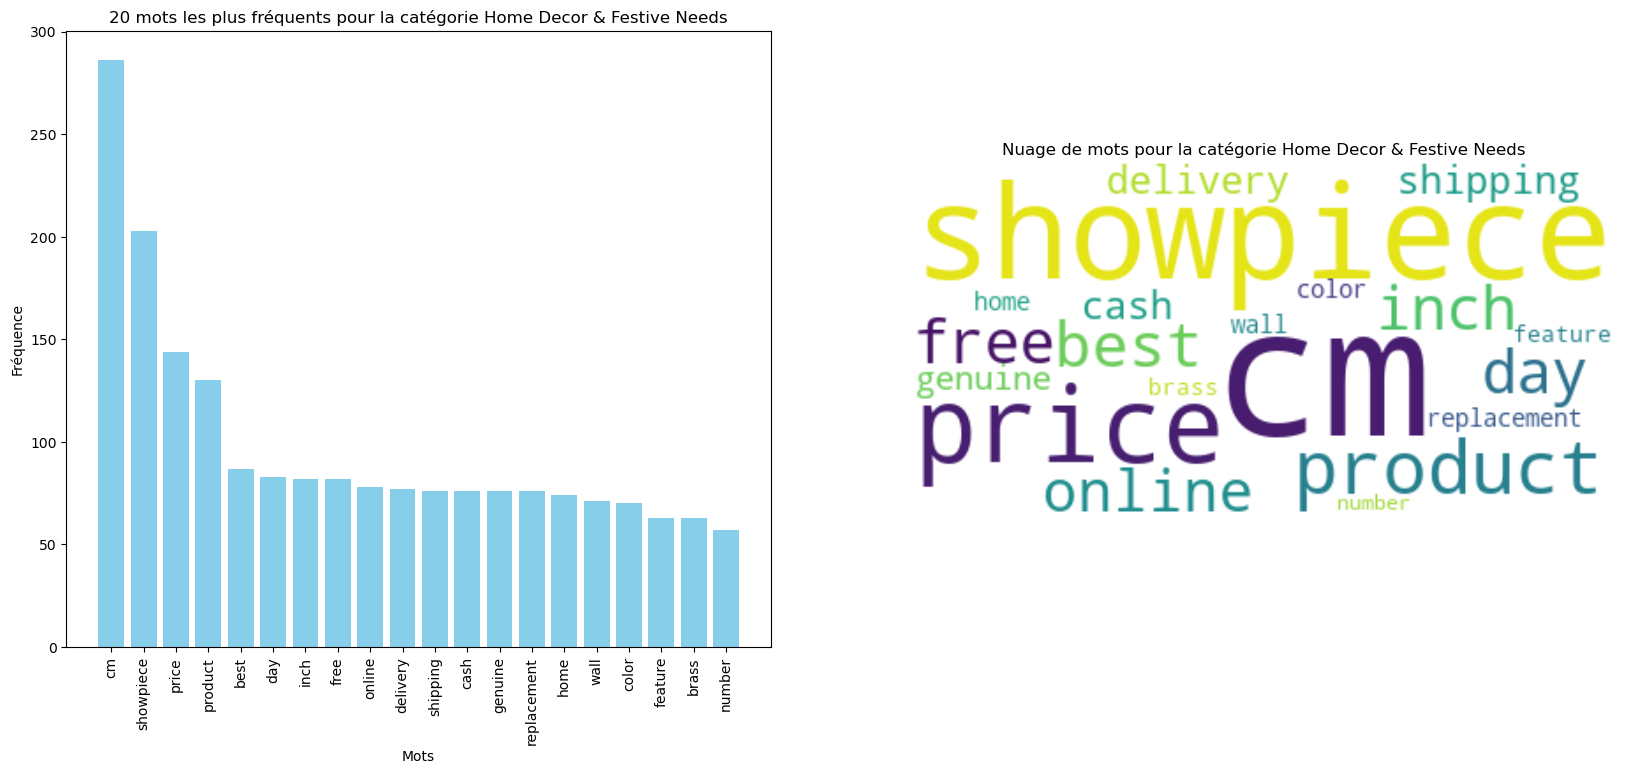

Pour la catégorie Home Furnishing
nb tokens 5545, nb tokens uniques 549
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'curtain', 'made', 'high', 'quality', 'polyester', 'feature', 'eyelet']


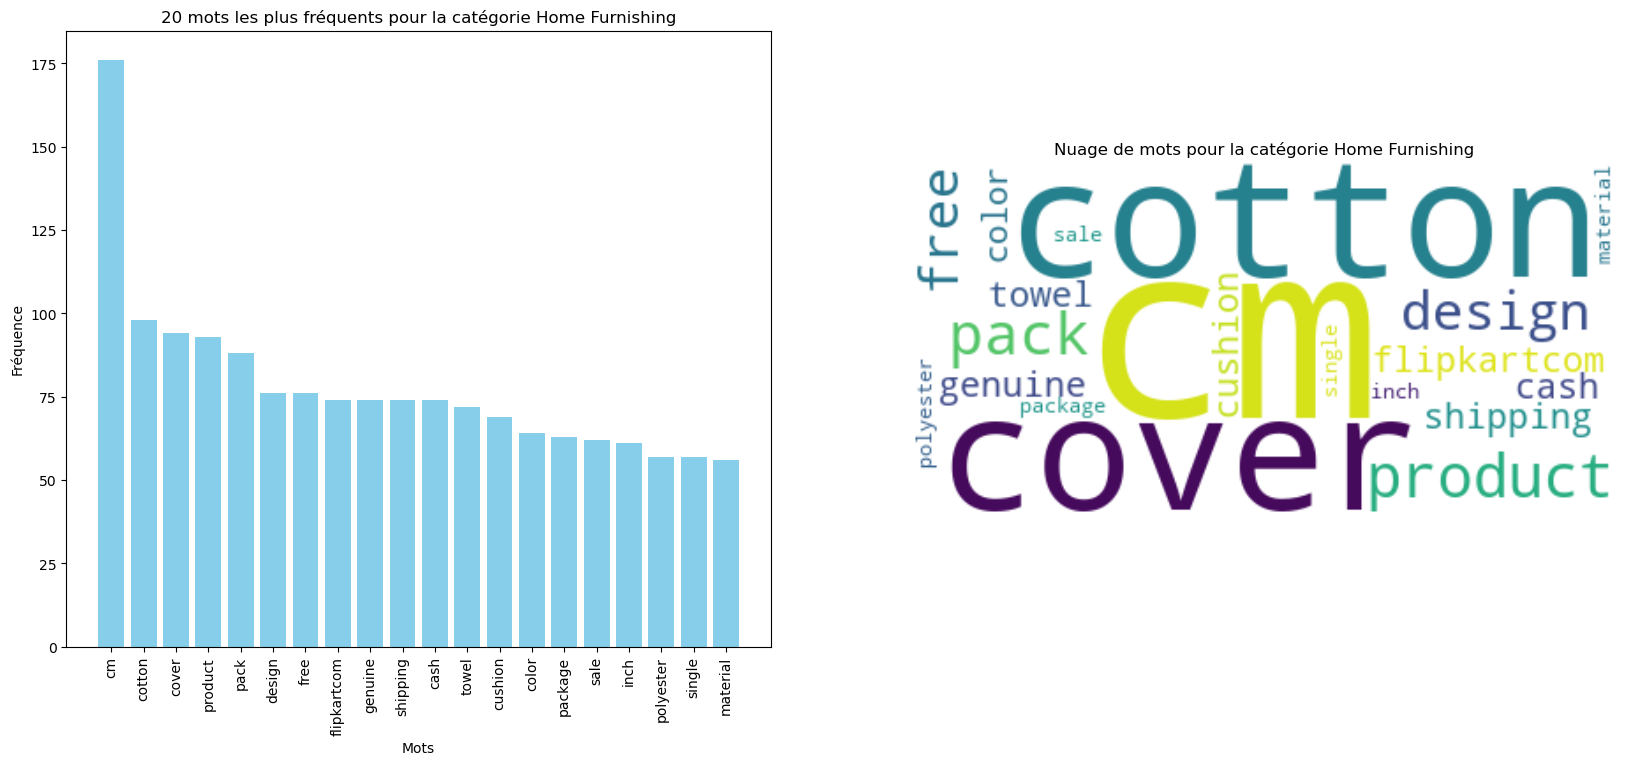

Pour la catégorie Kitchen & Dining
nb tokens 8698, nb tokens uniques 670
['key', 'feature', 'india', 'craft', 'glass', 'set', 'height', 'inch', 'dia', 'inch', 'depth', 'inch', 'width', 'ml', 'weight', 'india', 'craft', 'glass', 'set', 'copper', 'price', 'copper', 'utensil', 'serving', 'copper', 'prevent', 'spread', 'disease', 'many', 'copper']


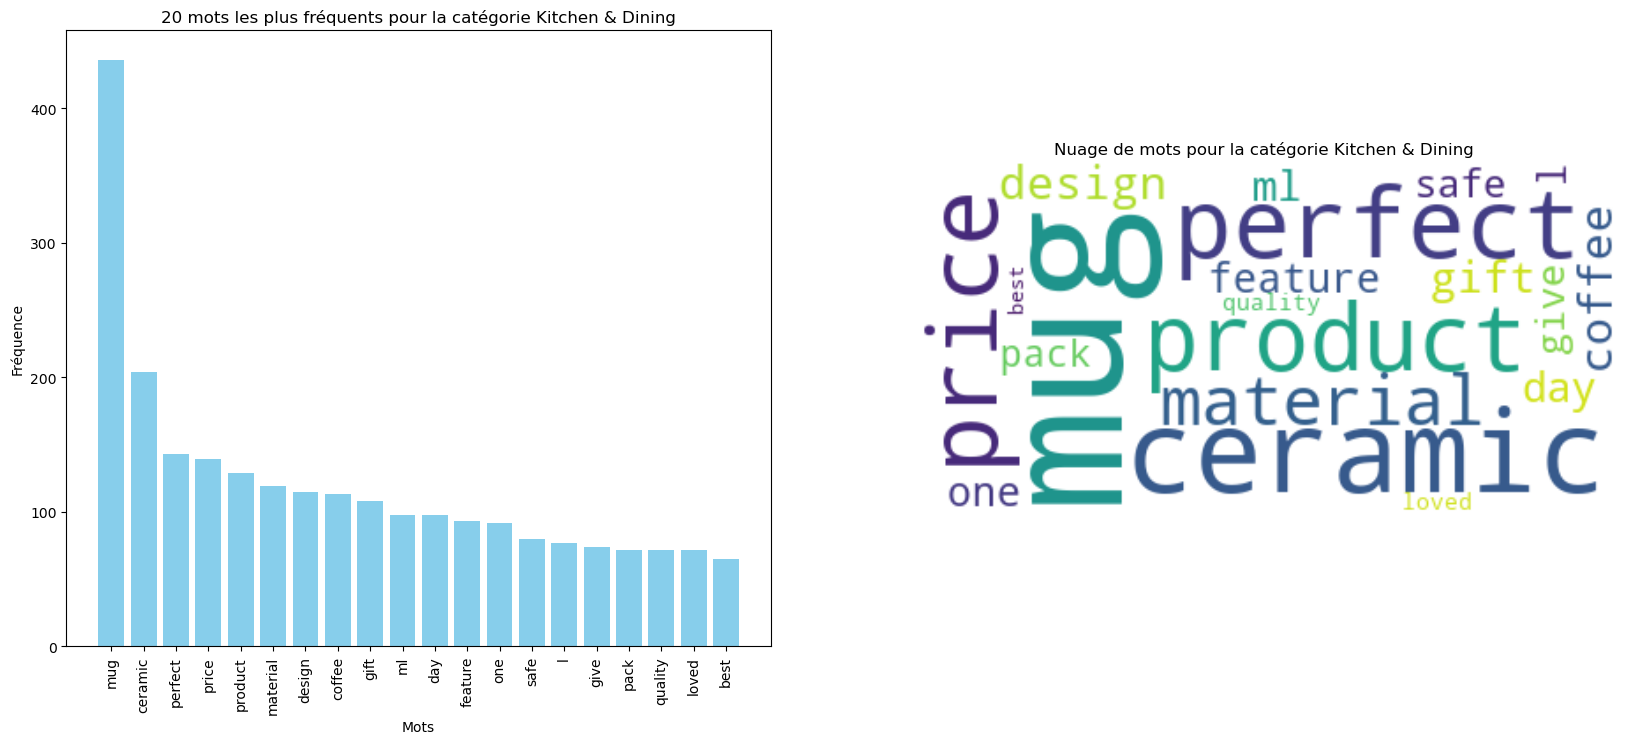

Pour la catégorie Watches
nb tokens 4566, nb tokens uniques 306
['time', 'analog', 'watch', 'boy', 'buy', 'time', 'analog', 'watch', 'boy', 'online', 'india', 'flipkartcom', 'great', 'discount', 'genuine', 'product', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'elegance', 'analog', 'watch', 'men', 'boy', 'buy', 'elegance', 'analog']


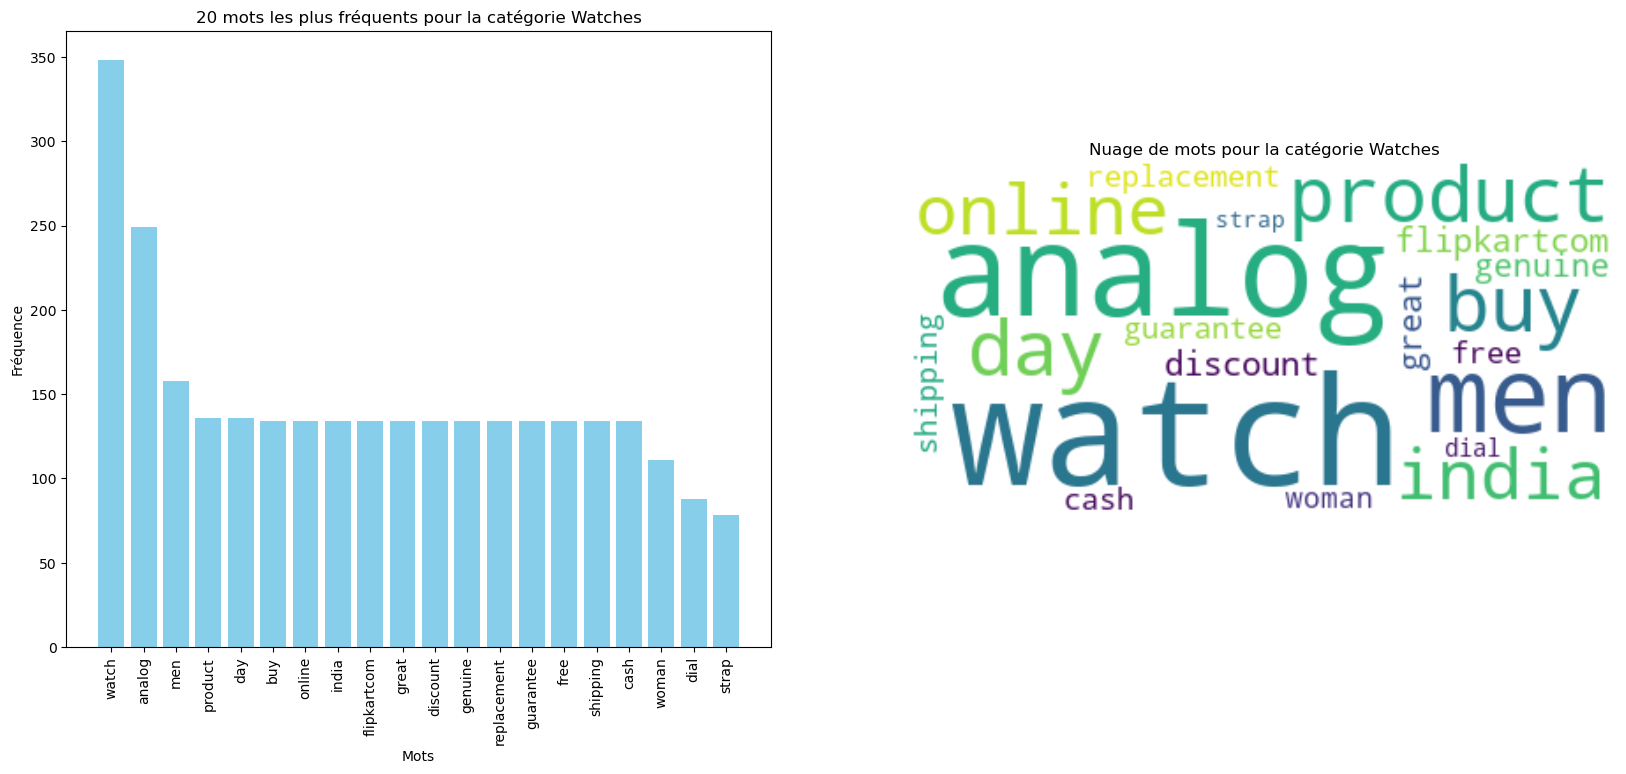

In [62]:
# Itérer sur chaque catégorie de produit
for category, group in df.groupby('product_category'):
    # Aplatir la liste de listes en une seule liste de tokens pour la catégorie actuelle
    all_tokens = [token for sublist in group['description'] for token in sublist]
    cat_corpus = "".join(all_tokens)

    # Traiter des données
    processed_cat_corpus = process_text(cat_corpus, clean=True, tokenize_method='word_tokenize',
                                        remove_stopwords=True, stemming=False,
                                        lemmatization=True, words_to_remove=combined_list)
    print(f'Pour la catégorie {category}')
    display_tokens_info(processed_cat_corpus)
    
    # Calculer la distribution de fréquence des tokens pour la catégorie
    freq_dist = FreqDist(processed_cat_corpus)
    
    # 20 mots les plus fréquents pour la catégorie
    common_words = freq_dist.most_common(20)
    
    # Séparation des mots et de leurs fréquences
    words, frequencies = zip(*common_words)
    
    # Préparation des subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    # Histogramme
    ax[0].bar(range(len(words)), frequencies, color='skyblue')
    ax[0].set_xlabel('Mots')
    ax[0].set_ylabel('Fréquence')
    ax[0].set_xticks(range(len(words)))
    ax[0].set_xticklabels(words, rotation=90)
    ax[0].set_title(f'20 mots les plus fréquents pour la catégorie {category}')
    
    # Création d'un nuage de mots pour la catégorie
    common_words_dict = dict(common_words)
    wordcloud = WordCloud(width=400, height=200, background_color='white',
                          min_font_size=10).generate_from_frequencies(common_words_dict)
    
    # Affichage du nuage de mots
    ax[1].imshow(wordcloud, interpolation="bilinear")
    ax[1].axis('off')
    ax[1].set_title(f'Nuage de mots pour la catégorie {category}')
    
    plt.show()

## Bag of Words

In [175]:
vectorizer_bow = CountVectorizer(min_df=0.003, max_df=0.7)
bow_matrix = vectorizer_bow.fit_transform(preprocessed_texts)

In [176]:
bow_matrix.shape

(1050, 1135)

## Tf-idf

In [185]:
vectorizer_tfidf = TfidfVectorizer(min_df=0.003, max_df=0.7)
tfidf_matrix = vectorizer_tfidf.fit_transform(preprocessed_texts)

In [186]:
tfidf_matrix.shape

(1050, 1135)

## Word2Vec

In [195]:
# Training the Word2Vec model
model = Word2Vec(sentences=processed_docs, vector_size=300, window=5, min_count=2, workers=4,
                sg=1, 
                hs=0, 
                negative=5, 
                epochs=50, 
                alpha=0.025, 
                sample=1e-4,
                seed=42)

# Summarize the loaded model
print(model)

Word2Vec<vocab=1479, vector_size=300, alpha=0.025>


In [196]:
def document_vector(word2vec_model, doc):
    # Suppression des mots hors vocabulaire
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    return np.mean(word2vec_model.wv[doc], axis=0)

# Création de la matrice de caractéristiques pour les documents
doc_vectors = np.array([document_vector(model, doc) for doc in processed_docs])

## BERT

In [205]:
# Chargement du tokenizer et du modèle
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [215]:
def encode_documents(docs, tokenizer, model, batch_size=10, device='cuda'):
    model.to(device)
    embeddings = []

    for i in range(0, len(docs), batch_size):
        batch = docs[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Prendre le CLS token embedding
        # cls_embeddings = outputs.last_hidden_state[:, 0, :]
        # embeddings.append(cls_embeddings.cpu())  # Retour au CPU si nécessaire

        # Max pooling
        max_pooled_embeddings = torch.max(outputs.last_hidden_state, dim=1).values
        embeddings.append(max_pooled_embeddings.cpu())

        # Moyenne des états cachés pour obtenir l'embedding du document
        # batch_embeddings = outputs.last_hidden_state.mean(1)
        # embeddings.append(batch_embeddings.cpu())  # Retour au CPU si nécessaire
    
    # Concatenate all embeddings
    embeddings = torch.cat(embeddings)

    # Normalisez les embeddings
    embeddings = embeddings.numpy()
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)

    return normalized_embeddings

In [216]:
embeddings_matrix = encode_documents(df['description'].tolist(), tokenizer, model, batch_size=16, device='cuda')

In [208]:
embeddings_matrix[:2]

tensor([[1.8486, 1.5761, 1.7227,  ..., 0.9318, 1.2591, 1.3742],
        [1.4563, 1.1756, 1.6560,  ..., 0.4580, 0.6611, 1.0761]])

## Universal Sentence Encoder (USE)

In [224]:
# Chargement du modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def encode_document_with_USE(doc):
    # Utilisation de l'API pour charger le modèle
    return embed([doc])

# Encodage de tous les documents
doc_embeddings_USE = np.array([encode_document_with_USE(doc).numpy()[0] for doc in preprocessed_texts])

In [75]:
doc_embeddings_USE[:3]

array([[-0.05549284, -0.0553027 ,  0.04616314, ...,  0.04865442,
         0.04878314, -0.0482562 ],
       [-0.03087286, -0.04535445, -0.00206622, ...,  0.04139815,
         0.02731982,  0.02293224],
       [-0.05382951, -0.04817661, -0.03203731, ...,  0.05027171,
        -0.01064726, -0.03047359]], dtype=float32)

## LDA

## NMF

## Réduction de dimension

### ACP

#### Sur BoW

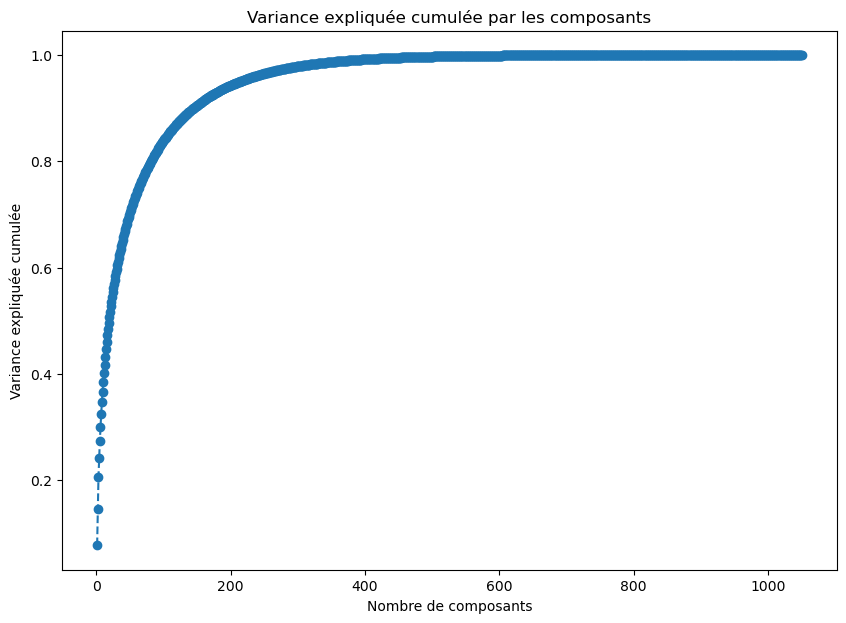

In [177]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(bow_matrix.toarray())

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [178]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1

print(f"Nombre de composantes pour atteindre 90% de variance expliquée : {n_components_90}")

Nombre de composantes pour atteindre 90% de variance expliquée : 144


In [179]:
# PCA
pca = PCA(n_components=n_components_90)
reduced_bow = pca.fit_transform(bow_matrix.toarray())

#### Sur Tf-idf

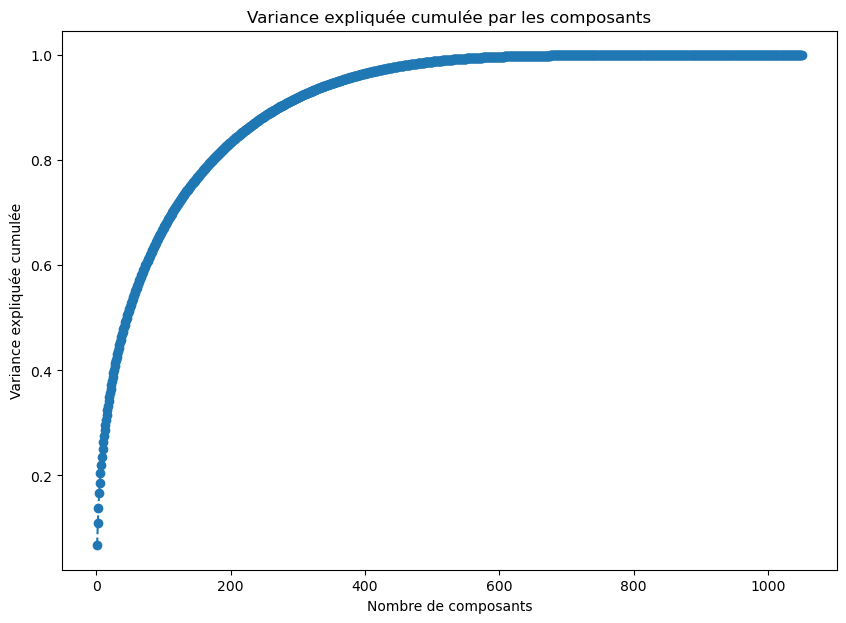

In [187]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [188]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1

print(f"Nombre de composantes pour atteindre 90% de variance expliquée : {n_components_90}")

Nombre de composantes pour atteindre 90% de variance expliquée : 271


In [189]:
# PCA
pca = PCA(n_components=n_components_90)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())

#### Sur Word2vec

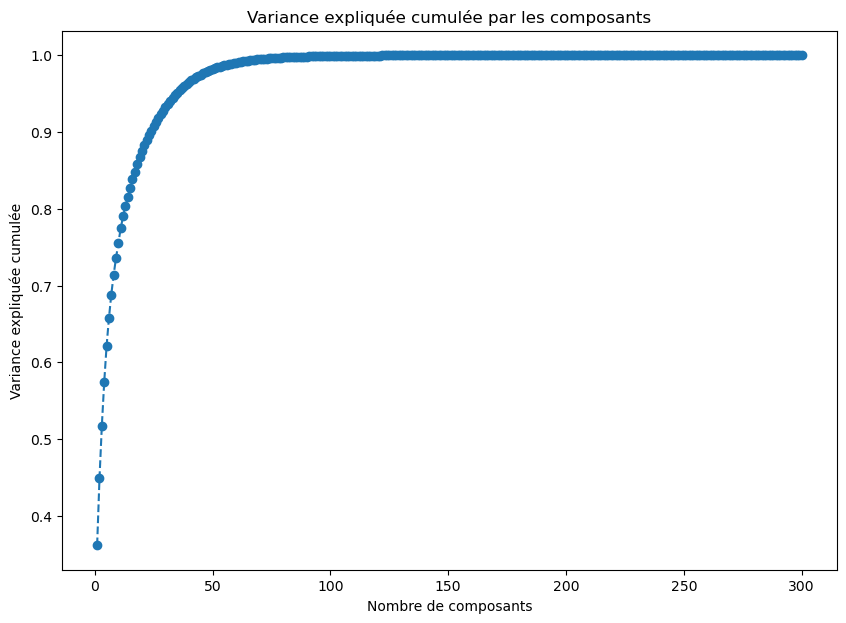

In [197]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(doc_vectors)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [198]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.999)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99.9% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99.9% de variance expliquée : 100


In [199]:
# PCA
pca = PCA(n_components=n_components_99)
reduced_w2v = pca.fit_transform(doc_vectors)

#### Sur BERT

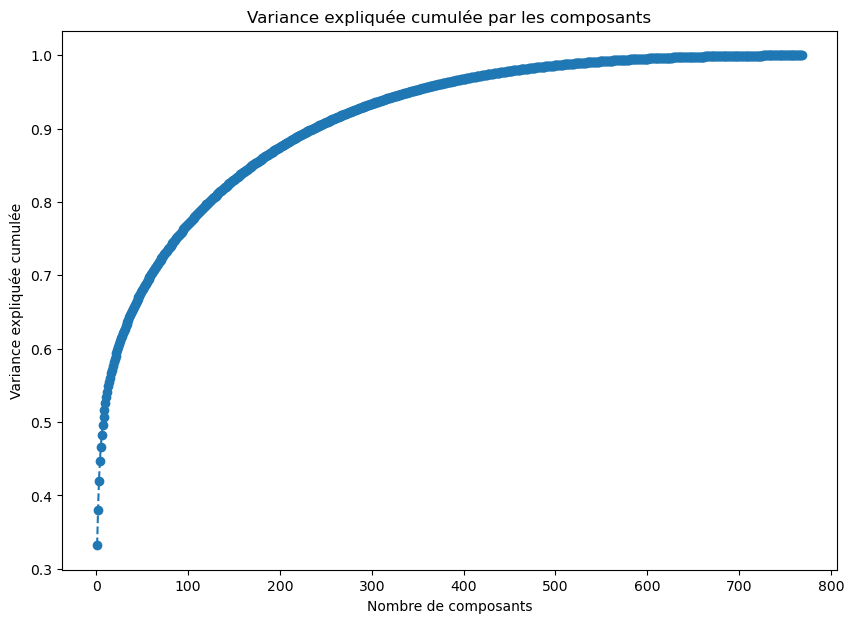

In [217]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(embeddings_matrix)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [218]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1

print(f"Nombre de composantes pour atteindre 90% de variance expliquée : {n_components_90}")

Nombre de composantes pour atteindre 90% de variance expliquée : 237


In [219]:
# PCA
pca = PCA(n_components=n_components_90)
reduced_bert = pca.fit_transform(embeddings_matrix)

#### Sur USE

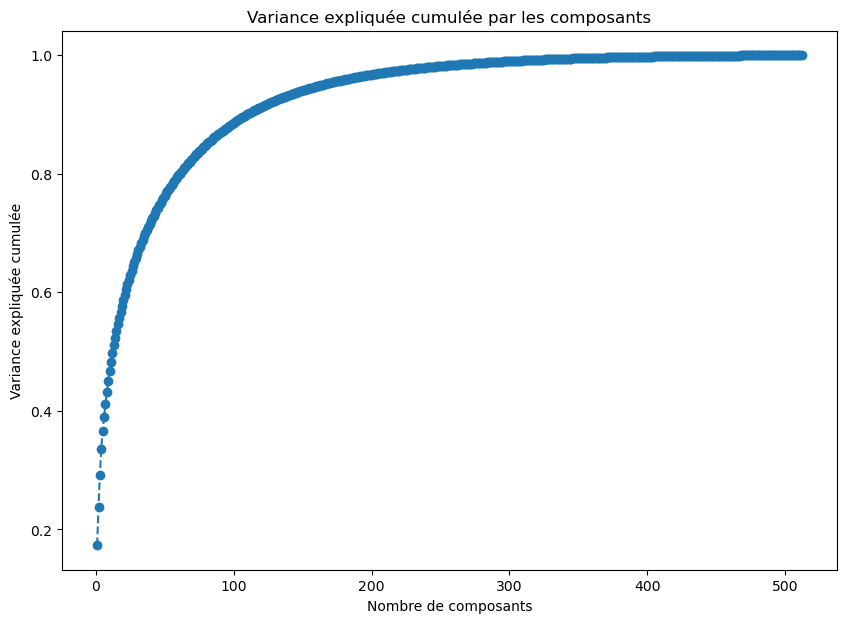

In [228]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(doc_embeddings_USE)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [229]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

print(f"Nombre de composantes pour atteindre 95% de variance expliquée : {n_components_95}")

Nombre de composantes pour atteindre 95% de variance expliquée : 165


In [230]:
# PCA
pca = PCA(n_components=n_components_95)
reduced_use = pca.fit_transform(doc_embeddings_USE)

### T-SNE

In [147]:
# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])

#### Sur BoW

In [181]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, random_state=42)
tsne_bow = tsne.fit_transform(bow_matrix.toarray())

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.558602
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.359406
[t-SNE] KL divergence after 1000 iterations: 0.706781


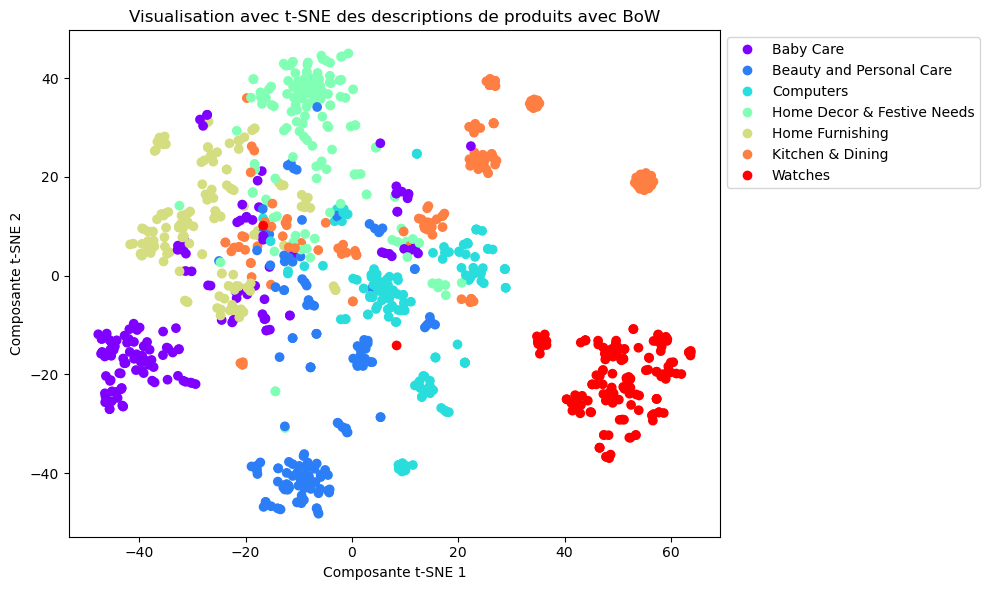

In [182]:
# Visualisation avec t-SNE
plt.figure(figsize=(10, 6))
unique_categories = np.unique(categories_encoded)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
scatter = plt.scatter(tsne_bow[:, 0], tsne_bow[:, 1], c=categories_encoded, cmap='rainbow')

# Création de la légende
handles = [plt.Line2D([0], [0], marker='o', color=colors[i], label=label_encoder.classes_[i],
                      linestyle='') for i in range(len(unique_categories))]
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))

# Ajout des labels aux axes
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')

# Titre du graphique
plt.title('Visualisation avec t-SNE des descriptions de produits avec BoW')

# Ajustement de la disposition pour tenir compte de la légende
plt.tight_layout()

plt.show()

#### Sur Tf-idf

In [190]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, random_state=42)
tsne_tfidf= tsne.fit_transform(tfidf_matrix.toarray())

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.435372
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.188805
[t-SNE] KL divergence after 1000 iterations: 0.596548


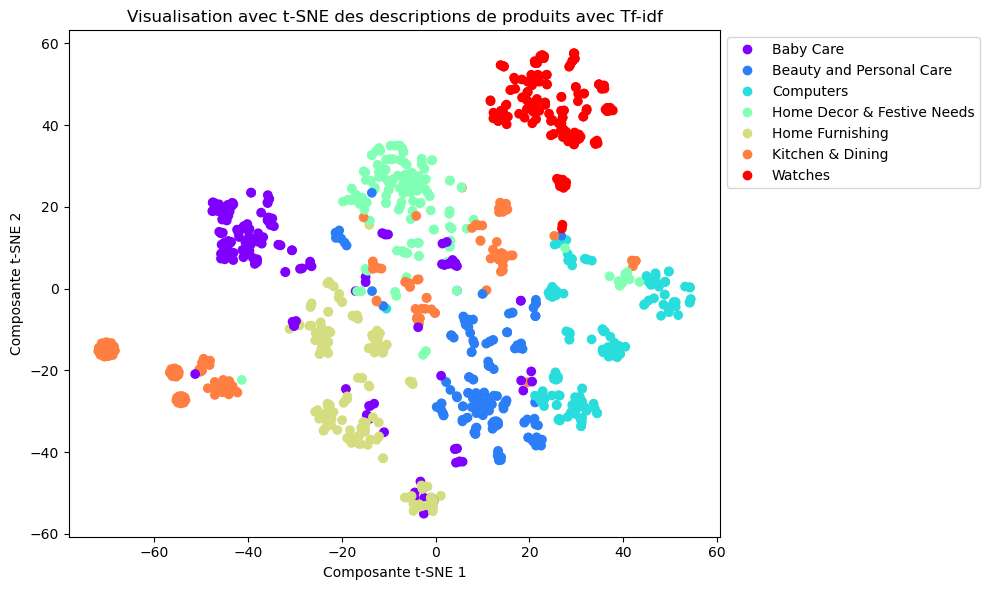

In [191]:
# Visualisation avec t-SNE
plt.figure(figsize=(10, 6))
unique_categories = np.unique(categories_encoded)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
scatter = plt.scatter(tsne_tfidf[:, 0], tsne_tfidf[:, 1], c=categories_encoded, cmap='rainbow')

# Création de la légende
handles = [plt.Line2D([0], [0], marker='o', color=colors[i], label=label_encoder.classes_[i],
                      linestyle='') for i in range(len(unique_categories))]
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))

# Ajout des labels aux axes
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')

# Titre du graphique
plt.title('Visualisation avec t-SNE des descriptions de produits avec Tf-idf')

# Ajustement de la disposition pour tenir compte de la légende
plt.tight_layout()

plt.show()

#### Sur Word2vec

In [200]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, random_state=42)
tsne_w2v = tsne.fit_transform(doc_vectors)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.000s...
[t-SNE] Computed neighbors for 1050 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.437149
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.186016
[t-SNE] KL divergence after 1000 iterations: 0.398583


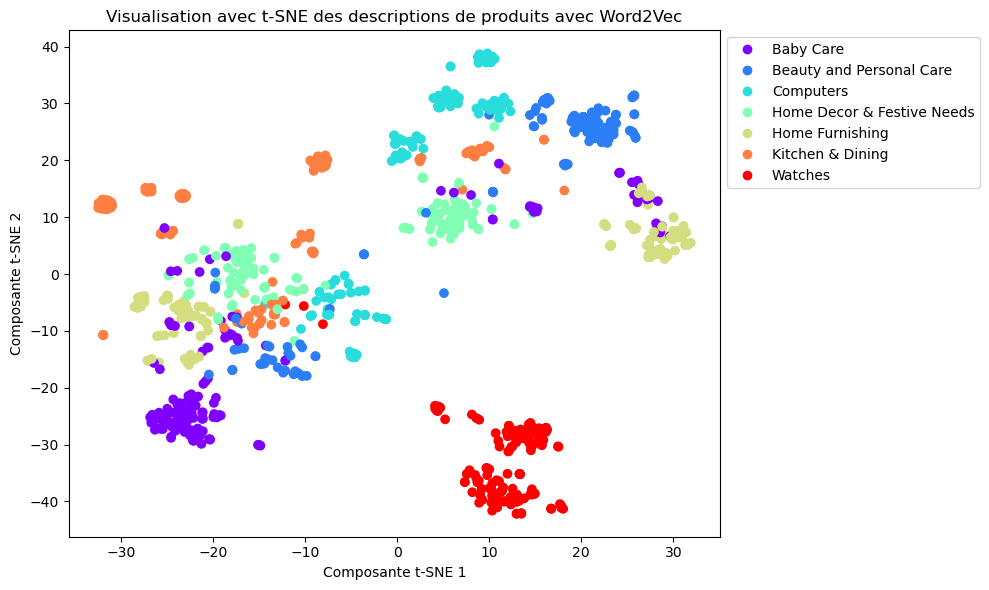

In [201]:
# Visualisation avec t-SNE
plt.figure(figsize=(10, 6))
unique_categories = np.unique(categories_encoded)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
scatter = plt.scatter(tsne_w2v[:, 0], tsne_w2v[:, 1], c=categories_encoded, cmap='rainbow')

# Création de la légende
handles = [plt.Line2D([0], [0], marker='o', color=colors[i], label=label_encoder.classes_[i],
                      linestyle='') for i in range(len(unique_categories))]
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))

# Ajout des labels aux axes
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')

# Titre du graphique
plt.title('Visualisation avec t-SNE des descriptions de produits avec Word2Vec')

# Ajustement de la disposition pour tenir compte de la légende
plt.tight_layout()

plt.show()

#### Sur BERT

In [220]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, random_state=42)
tsne_bert = tsne.fit_transform(embeddings_matrix)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 8.328777
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.703720
[t-SNE] KL divergence after 1000 iterations: 0.528901


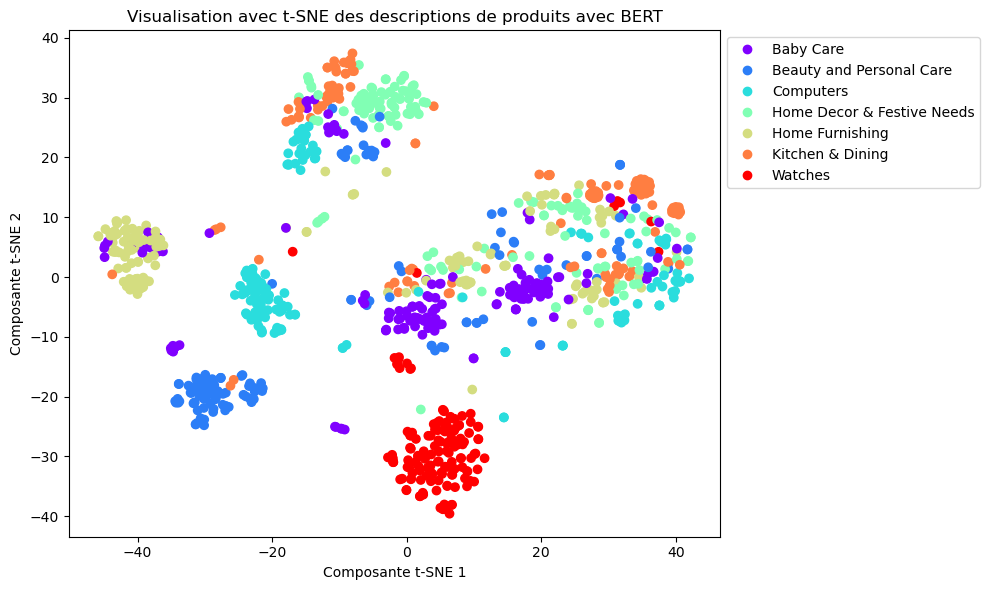

In [221]:
# Visualisation avec t-SNE
plt.figure(figsize=(10, 6))
unique_categories = np.unique(categories_encoded)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
scatter = plt.scatter(tsne_bert[:, 0], tsne_bert[:, 1], c=categories_encoded, cmap='rainbow')

# Création de la légende
handles = [plt.Line2D([0], [0], marker='o', color=colors[i], label=label_encoder.classes_[i],
                      linestyle='') for i in range(len(unique_categories))]
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))

# Ajout des labels aux axes
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')

# Titre du graphique
plt.title('Visualisation avec t-SNE des descriptions de produits avec BERT')

# Ajustement de la disposition pour tenir compte de la légende
plt.tight_layout()

plt.show()

#### Sur USE

In [231]:
tsne = TSNE(n_components=2, verbose=1, perplexity=15, random_state=42)
tsne_use = tsne.fit_transform(doc_embeddings_USE)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.000s...
[t-SNE] Computed neighbors for 1050 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.255419
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.479263
[t-SNE] KL divergence after 1000 iterations: 0.538660


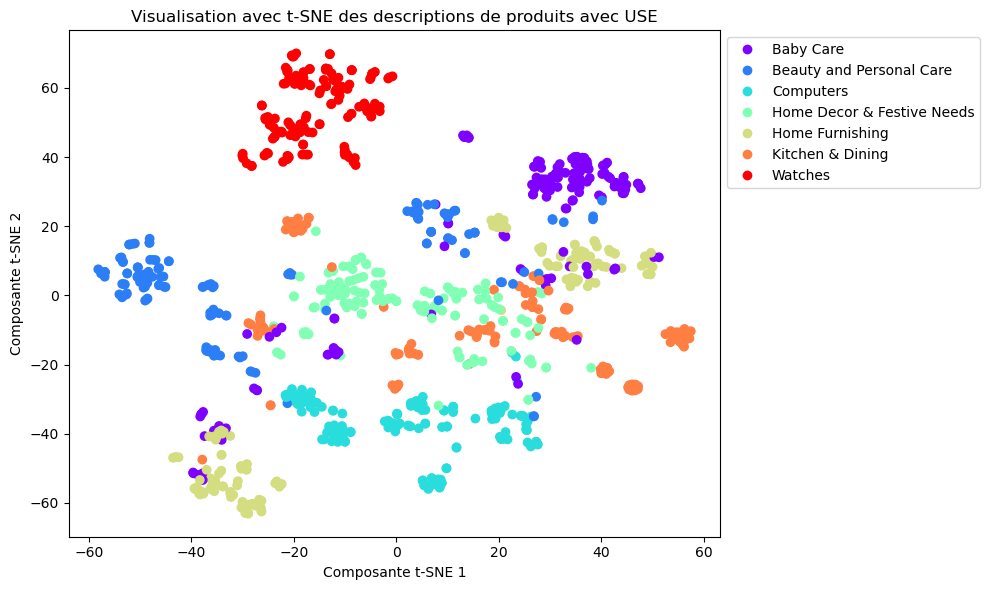

In [232]:
# Visualisation avec t-SNE
plt.figure(figsize=(10, 6))
unique_categories = np.unique(categories_encoded)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
scatter = plt.scatter(tsne_use[:, 0], tsne_use[:, 1], c=categories_encoded, cmap='rainbow')

# Création de la légende
handles = [plt.Line2D([0], [0], marker='o', color=colors[i], label=label_encoder.classes_[i],
                      linestyle='') for i in range(len(unique_categories))]
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))

# Ajout des labels aux axes
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')

# Titre du graphique
plt.title('Visualisation avec t-SNE des descriptions de produits avec USE')

# Ajustement de la disposition pour tenir compte de la légende
plt.tight_layout()

plt.show()

# K-means

In [173]:
# Nombre de clusters
n_clusters = 7

# Vraie catégories pour comparaison
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

## sur BoW

Silhouette Score: 0.5001
Adjusted Rand Score: 0.4405
Accuracy: 0.7000


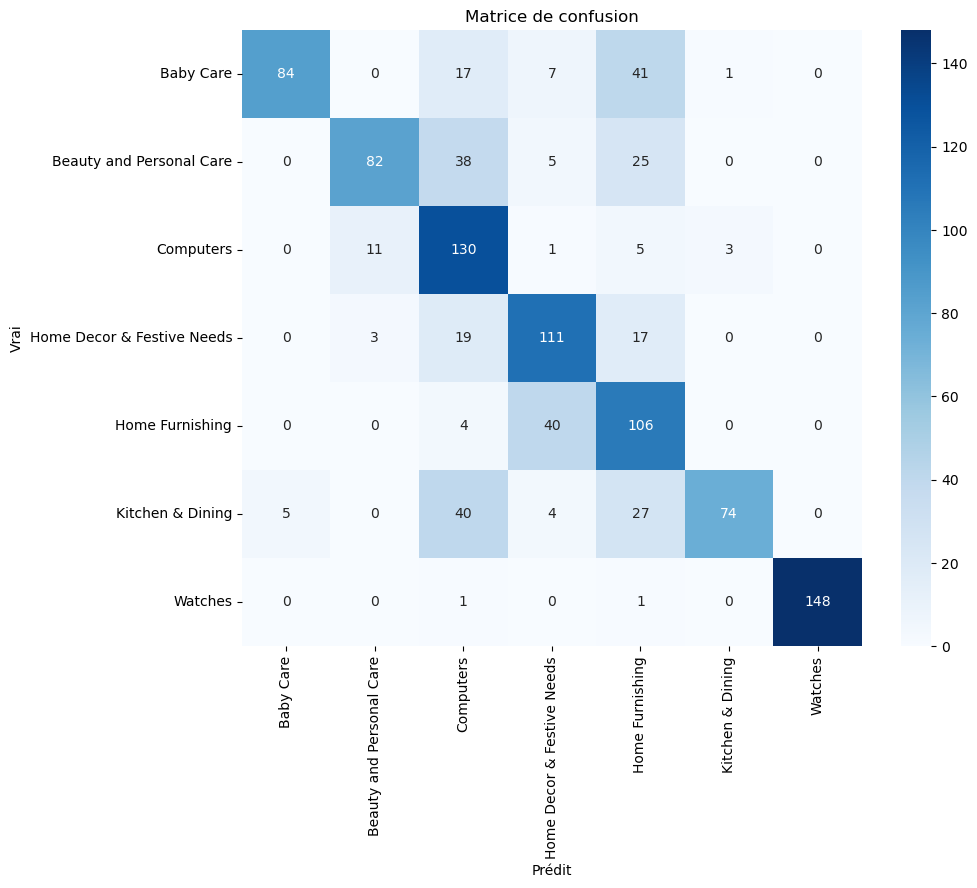

In [183]:
kmeans_silhouette_avg_bow, kmeans_ari_score_bow, kmeans_accu_bow, kmeans_clusters_bow = perform_kmeans(X_data=tsne_bow,
                                                                                                       true_labels=true_labels_encoded,
                                                                                                       label_names=category_names,
                                                                                                       n_clusters=n_clusters,
                                                                                                       random_state=42)

## Sur Tf-idf

Silhouette Score: 0.4931
Adjusted Rand Score: 0.5389
Accuracy: 0.7562


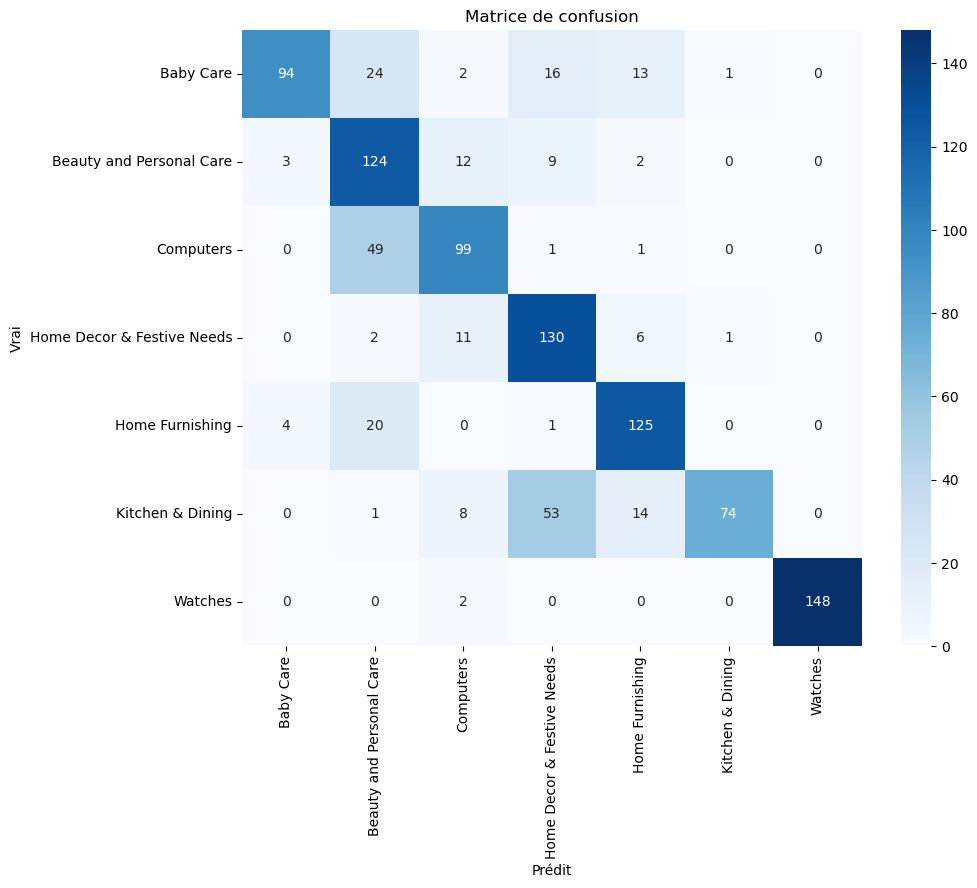

In [192]:
kmeans_silhouette_avg_tfidf, kmeans_ari_score_tfidf, kmeans_accu_tfidf, kmeans_clusters_tfidf = perform_kmeans(X_data=tsne_tfidf,
                                                                                                              true_labels=true_labels_encoded,
                                                                                                              label_names=category_names,
                                                                                                              n_clusters=n_clusters,
                                                                                                              random_state=42)

## Sur Word2vec

Silhouette Score: 0.5057
Adjusted Rand Score: 0.3431
Accuracy: 0.5676


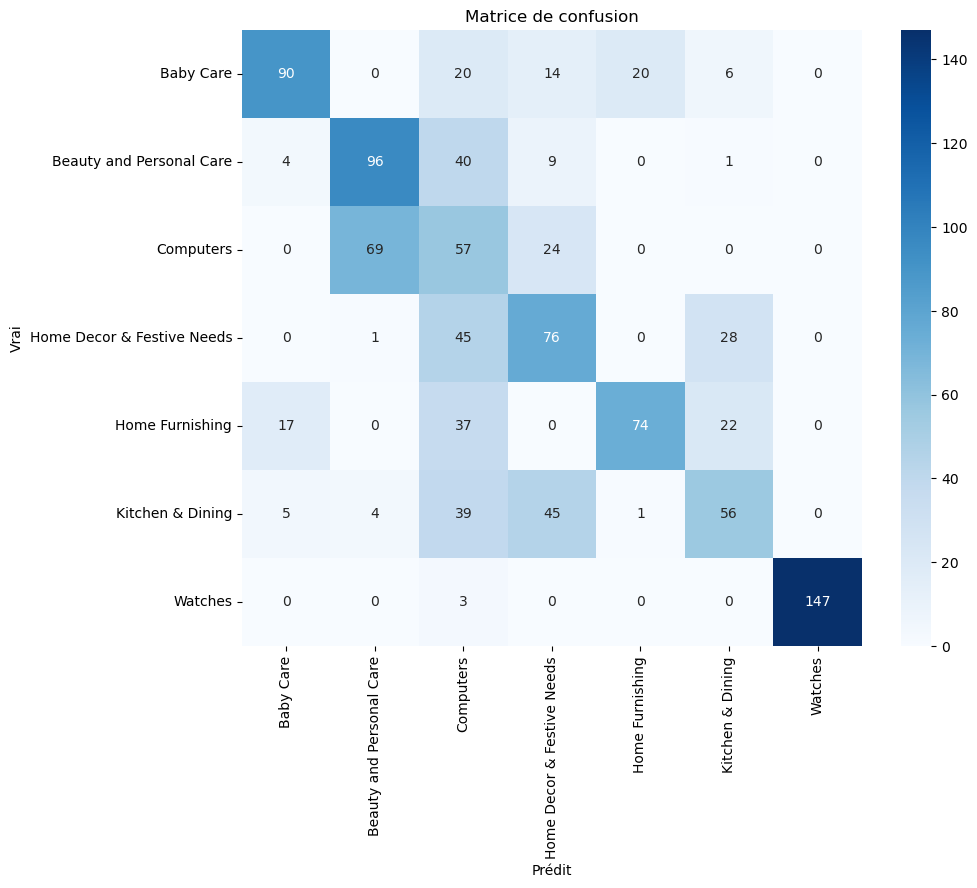

In [202]:
kmeans_silhouette_avg_w2v, kmeans_ari_score_w2v, kmeans_accu_w2v, kmeans_clusters_w2v = perform_kmeans(X_data=tsne_w2v,
                                                                                                       true_labels=true_labels_encoded,
                                                                                                       label_names=category_names,
                                                                                                       n_clusters=n_clusters,
                                                                                                       random_state=42)

## Sur BERT

Silhouette Score: 0.5930
Adjusted Rand Score: 0.2790
Accuracy: 0.5695


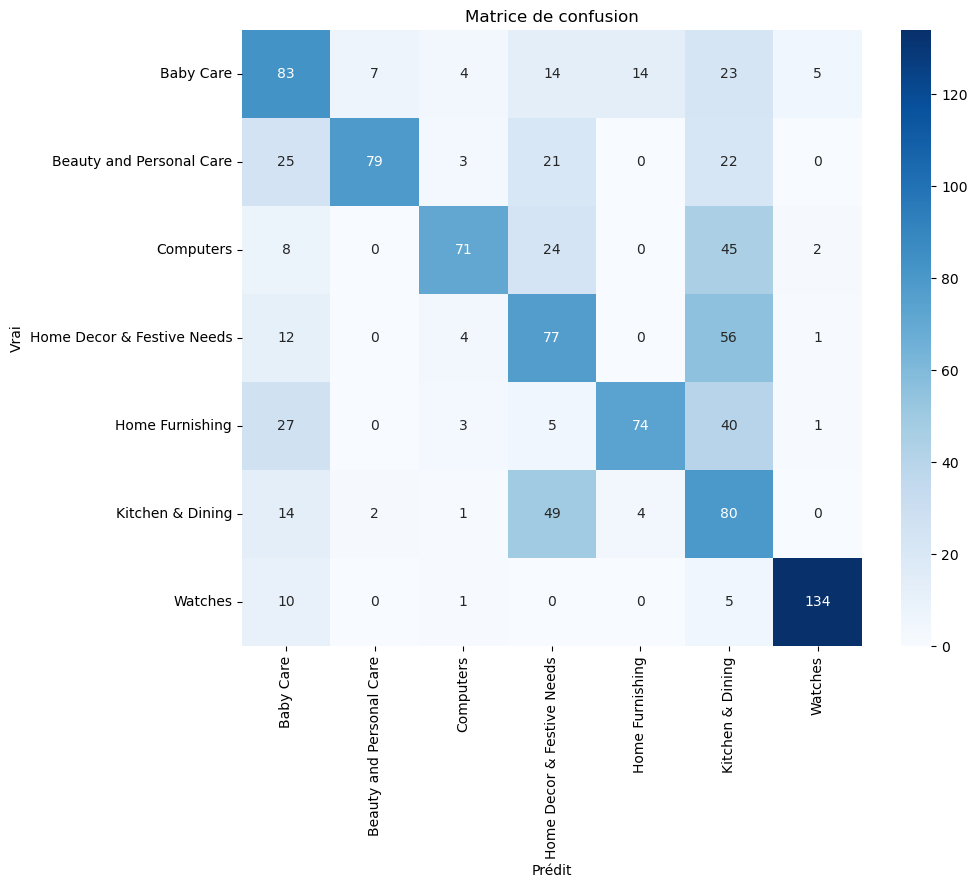

In [222]:
kmeans_silhouette_avg_bert, kmeans_ari_score_bert, kmeans_accu_bert, kmeans_clusters_bert = perform_kmeans(X_data=tsne_bert,
                                                                                                           true_labels=true_labels_encoded,
                                                                                                           label_names=category_names,
                                                                                                           n_clusters=n_clusters,
                                                                                                           random_state=42)

## Sur USE

Silhouette Score: 0.4715
Adjusted Rand Score: 0.4419
Accuracy: 0.6676


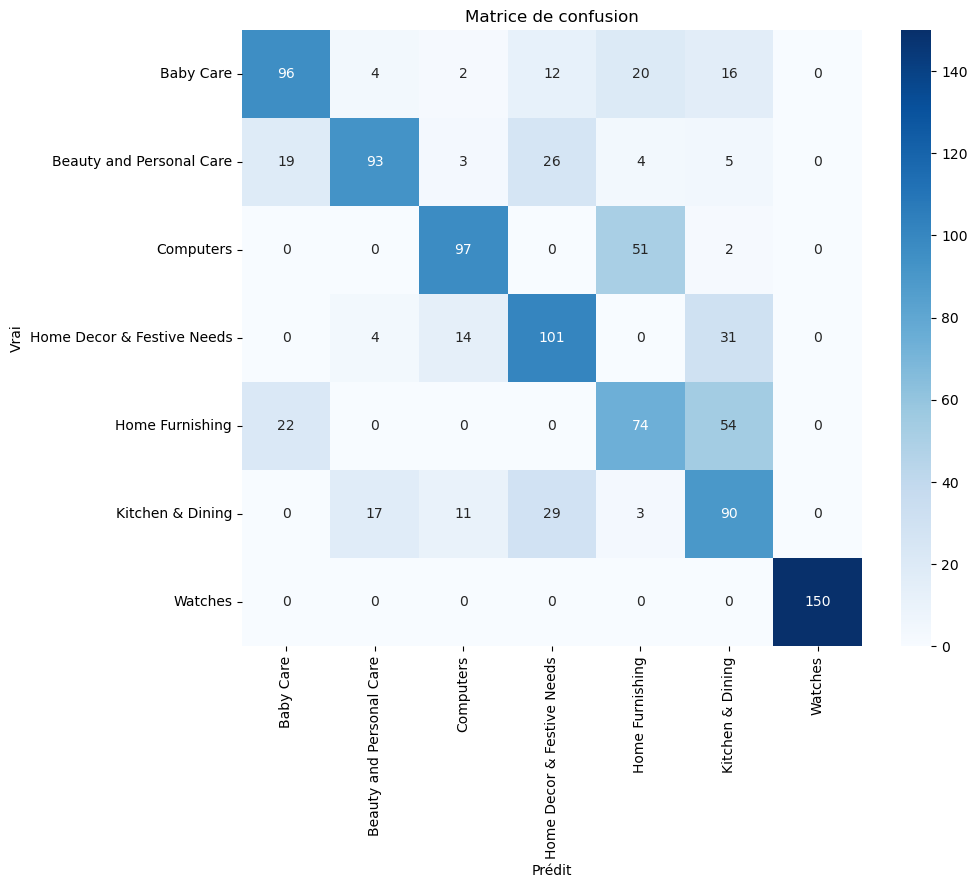

In [233]:
kmeans_silhouette_avg_use, kmeans_ari_score_use, kmeans_accu_use, kmeans_clusters_use = perform_kmeans(X_data=tsne_use,
                                                                                                       true_labels=true_labels_encoded,
                                                                                                       label_names=category_names,
                                                                                                       n_clusters=n_clusters,
                                                                                                       random_state=42)

# Modèles de machine learning supervisé

## Sur BoW

In [108]:
# Sur les données non réduites
X_nr = bow_matrix
y = df['product_category'].values

# Diviser les données en ensembles d'entraînement et de test
X_train_nr, X_test_nr, y_train, y_test = train_test_split(X_nr, y, test_size=0.2, random_state=42)

In [109]:
# Sur les données réduites (ACP)
X = reduced_bow

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Naive Bayes

Cross-Validation Scores:
fit_time: 0.0018 (± 0.0004)
score_time: 0.0052 (± 0.0004)
test_Accuracy: 0.8405 (± 0.0267)
test_Adjusted Rand Score: 0.6682 (± 0.0474)
test_Recall: 0.8405 (± 0.0267)
test_Precision: 0.8657 (± 0.0213)
test_F1 Score: 0.8360 (± 0.0291)

Test Set Metrics:
Accuracy: 0.8429
Adjusted Rand Score: 0.6810
Recall: 0.8429
Precision: 0.8761
F1 Score: 0.8389


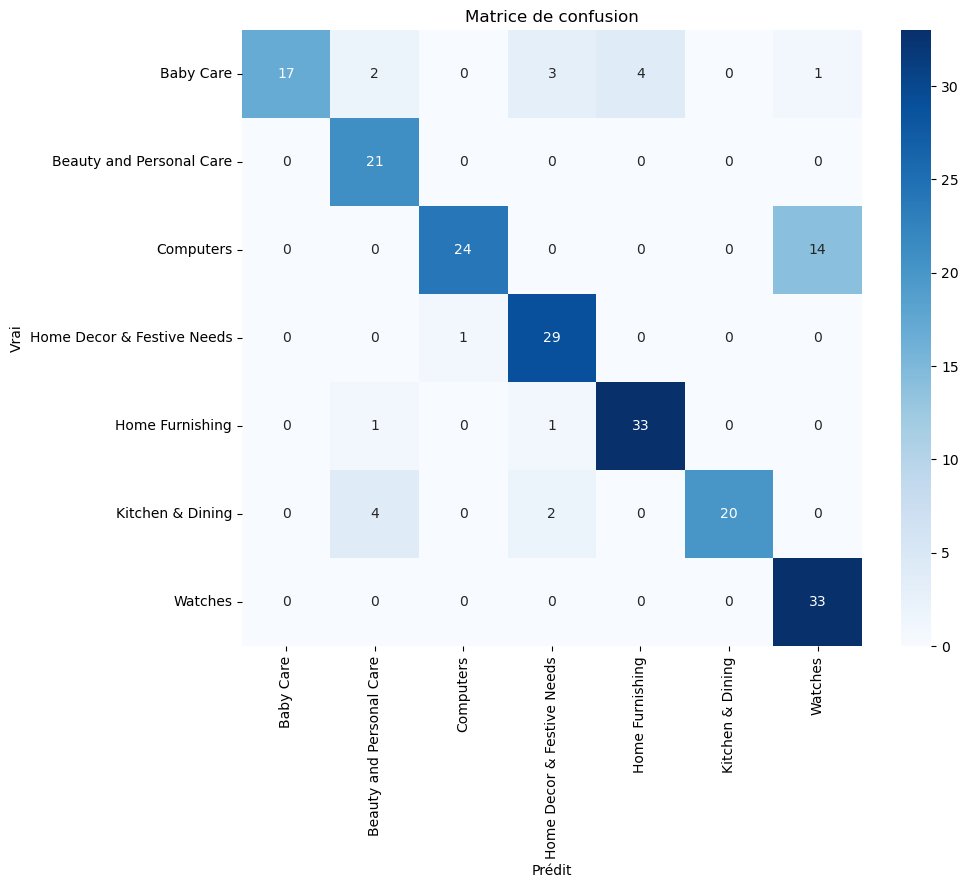

In [110]:
nb_model = MultinomialNB()
nb_accuracy_bow, nb_ari_score_bow, nb_recall_bow, nb_precision_bow, nb_f1_bow = perform_model_with_cross_validation(nb_model,
                                                                                                                    X_train_nr,
                                                                                                                    y_train,
                                                                                                                    X_test_nr,
                                                                                                                    y_test)

### SVM

Cross-Validation Scores:
fit_time: 0.0300 (± 0.0026)
score_time: 0.0150 (± 0.0011)
test_Accuracy: 0.8655 (± 0.0348)
test_Adjusted Rand Score: 0.7153 (± 0.0645)
test_Recall: 0.8655 (± 0.0348)
test_Precision: 0.8835 (± 0.0235)
test_F1 Score: 0.8639 (± 0.0364)

Test Set Metrics:
Accuracy: 0.8952
Adjusted Rand Score: 0.7795
Recall: 0.8952
Precision: 0.9092
F1 Score: 0.8948


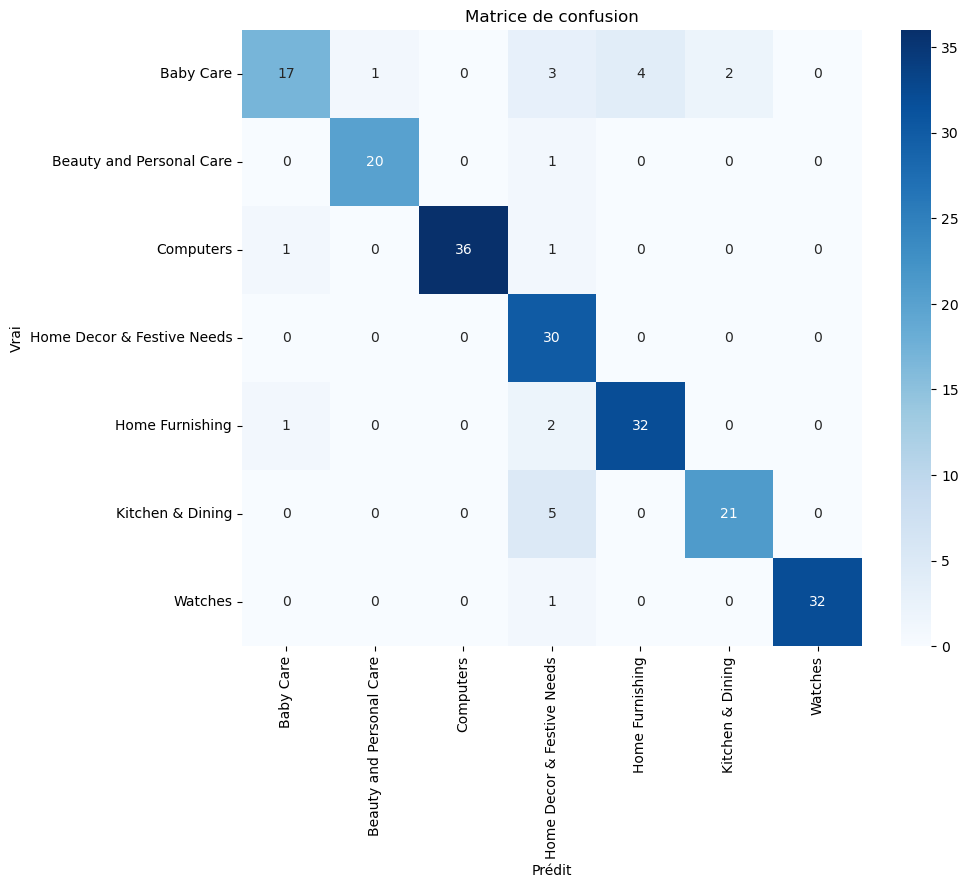

In [111]:
svm_model = SVC(random_state=42)
svm_accuracy_bow, svm_ari_score_bow, svm_recall_bow, svm_precision_bow, svm_f1_bow = perform_model_with_cross_validation(svm_model,
                                                                                                                         X_train,
                                                                                                                         y_train,
                                                                                                                         X_test,
                                                                                                                         y_test)

### Random Forest

Cross-Validation Scores:
fit_time: 0.6105 (± 0.0573)
score_time: 0.0142 (± 0.0019)
test_Accuracy: 0.8726 (± 0.0117)
test_Adjusted Rand Score: 0.7262 (± 0.0219)
test_Recall: 0.8726 (± 0.0117)
test_Precision: 0.8851 (± 0.0126)
test_F1 Score: 0.8741 (± 0.0115)

Test Set Metrics:
Accuracy: 0.9000
Adjusted Rand Score: 0.7995
Recall: 0.9000
Precision: 0.9004
F1 Score: 0.8991


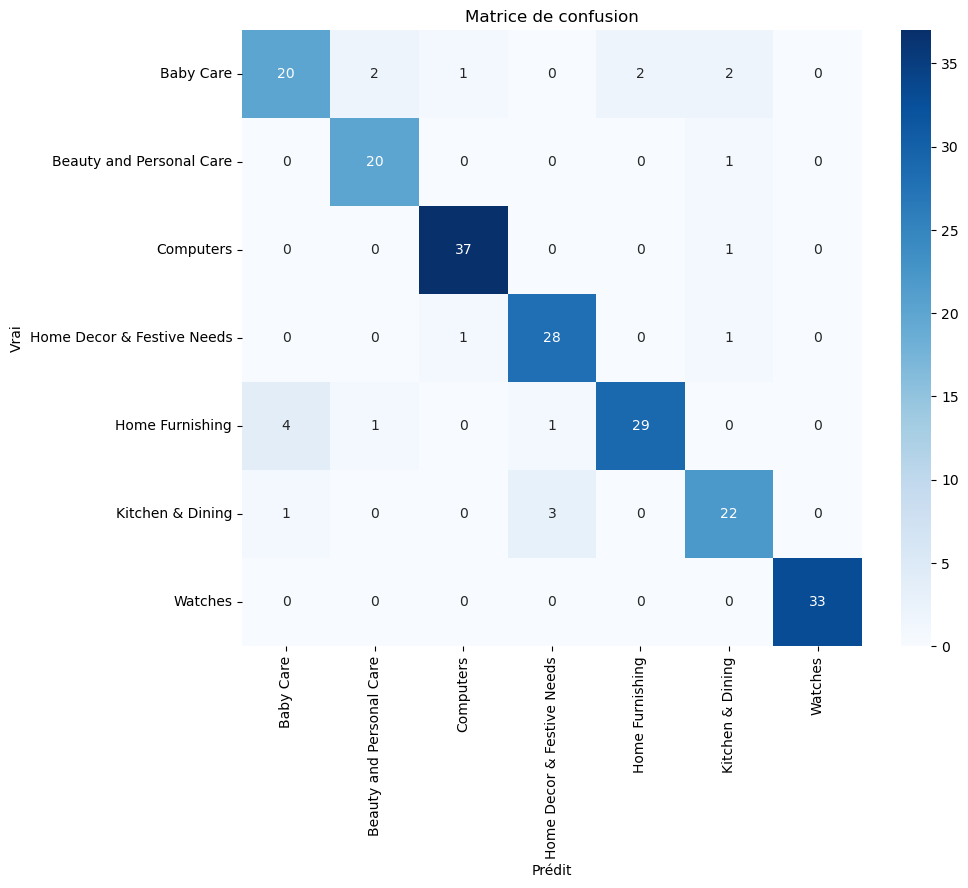

In [112]:
# Création d'une instance de RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Utilisation de la fonction perform_model_with_cross_validation avec le modèle RandomForestClassifier
rf_accuracy_bow, rf_ari_score_bow, rf_recall_bow, rf_precision_bow, rf_f1_bow = perform_model_with_cross_validation(rf_model,
                                                                                                                    X_train,
                                                                                                                    y_train,
                                                                                                                    X_test,
                                                                                                                    y_test)

## Sur Tf-idf

In [113]:
# Sur les données non réduites
X_nr = tfidf_matrix
y = df['product_category'].values

# Diviser les données en ensembles d'entraînement et de test
X_train_nr, X_test_nr, y_train, y_test = train_test_split(X_nr, y, test_size=0.2, random_state=42)

In [114]:
# Sur les données réduites (ACP)
X = reduced_tfidf

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Naive Bayes

Cross-Validation Scores:
fit_time: 0.0020 (± 0.0000)
score_time: 0.0050 (± 0.0000)
test_Accuracy: 0.8940 (± 0.0095)
test_Adjusted Rand Score: 0.7765 (± 0.0187)
test_Recall: 0.8940 (± 0.0095)
test_Precision: 0.9000 (± 0.0090)
test_F1 Score: 0.8918 (± 0.0101)

Test Set Metrics:
Accuracy: 0.9238
Adjusted Rand Score: 0.8371
Recall: 0.9238
Precision: 0.9340
F1 Score: 0.9231


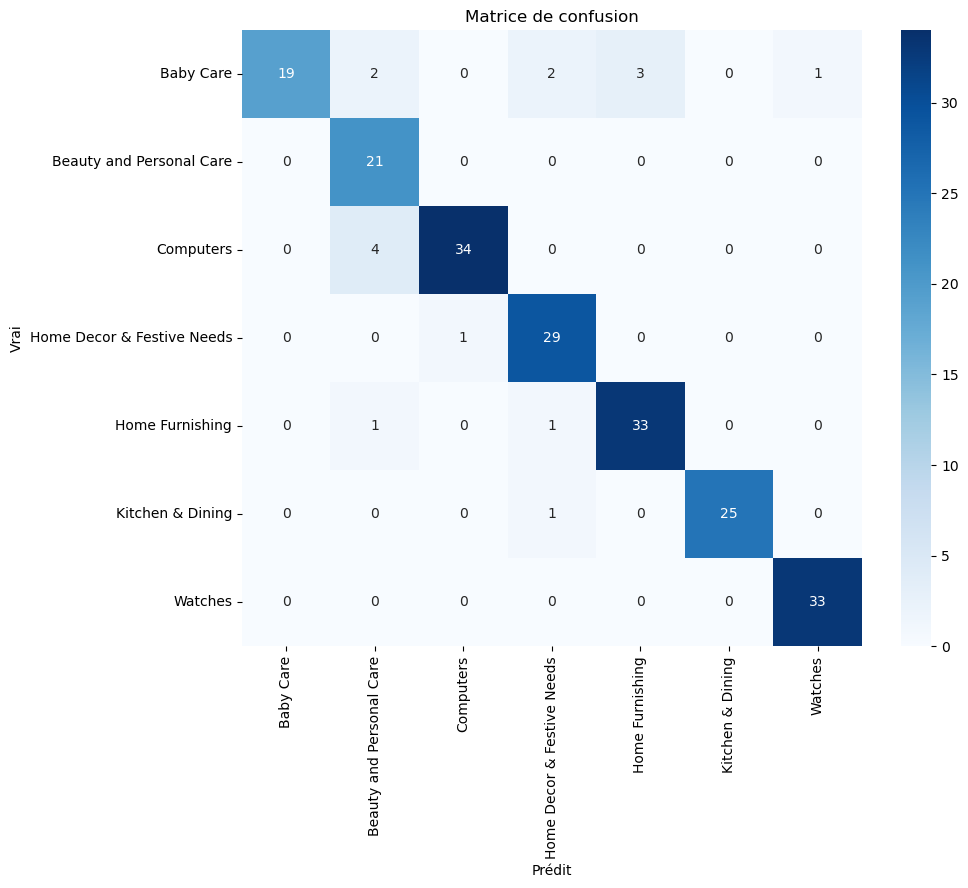

In [115]:
nb_model = MultinomialNB()
nb_accuracy_tfidf, nb_ari_score_tfidf, nb_recall_tfidf, nb_precision_tfidf, nb_f1_tfidf = perform_model_with_cross_validation(nb_model,
                                                                                                                              X_train_nr,
                                                                                                                              y_train,
                                                                                                                              X_test_nr,
                                                                                                                              y_test)

### SVM

Cross-Validation Scores:
fit_time: 0.0548 (± 0.0031)
score_time: 0.0163 (± 0.0006)
test_Accuracy: 0.9250 (± 0.0139)
test_Adjusted Rand Score: 0.8329 (± 0.0277)
test_Recall: 0.9250 (± 0.0139)
test_Precision: 0.9306 (± 0.0109)
test_F1 Score: 0.9243 (± 0.0143)

Test Set Metrics:
Accuracy: 0.9381
Adjusted Rand Score: 0.8713
Recall: 0.9381
Precision: 0.9412
F1 Score: 0.9363


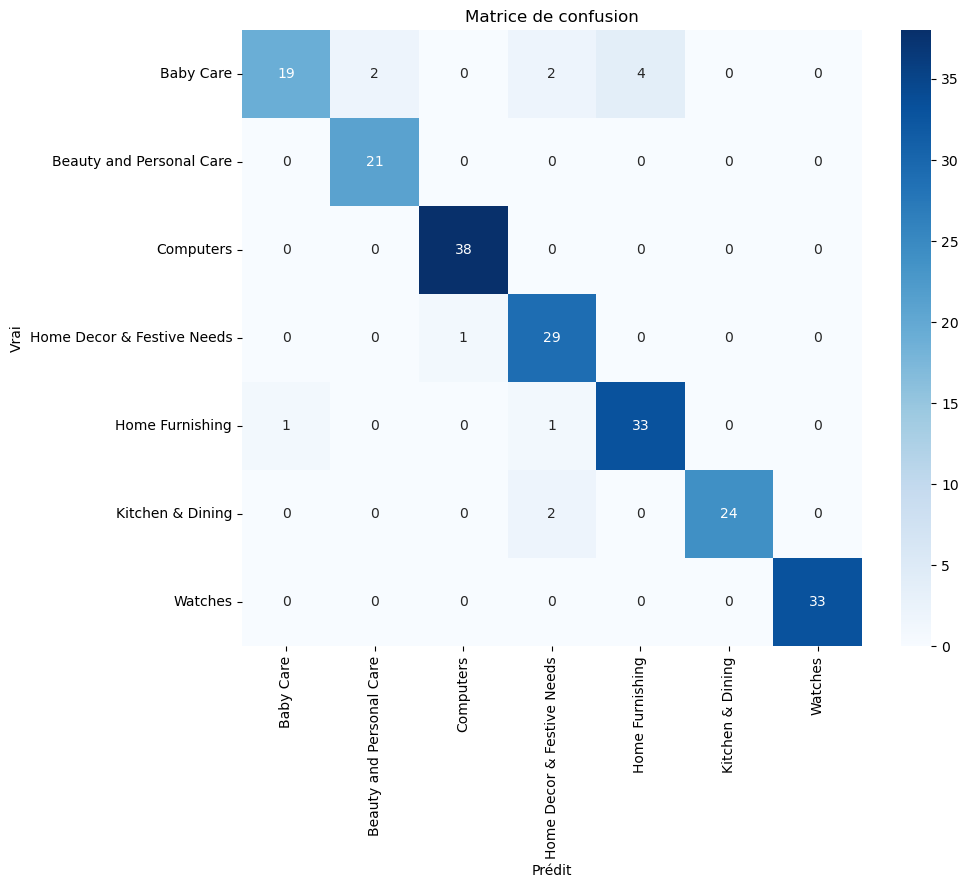

In [116]:
svm_model = SVC(random_state=42)
svm_accuracy_tfidf, svm_ari_score_tfidf, svm_recall_tfidf, svm_precision_tfidf, svm_f1_tfidf = perform_model_with_cross_validation(svm_model,
                                                                                                                                   X_train,
                                                                                                                                   y_train,
                                                                                                                                   X_test,
                                                                                                                                   y_test)

### Random Forest

Cross-Validation Scores:
fit_time: 0.8900 (± 0.0161)
score_time: 0.0132 (± 0.0004)
test_Accuracy: 0.9060 (± 0.0236)
test_Adjusted Rand Score: 0.7974 (± 0.0469)
test_Recall: 0.9060 (± 0.0236)
test_Precision: 0.9097 (± 0.0231)
test_F1 Score: 0.9047 (± 0.0238)

Test Set Metrics:
Accuracy: 0.9143
Adjusted Rand Score: 0.8221
Recall: 0.9143
Precision: 0.9180
F1 Score: 0.9142


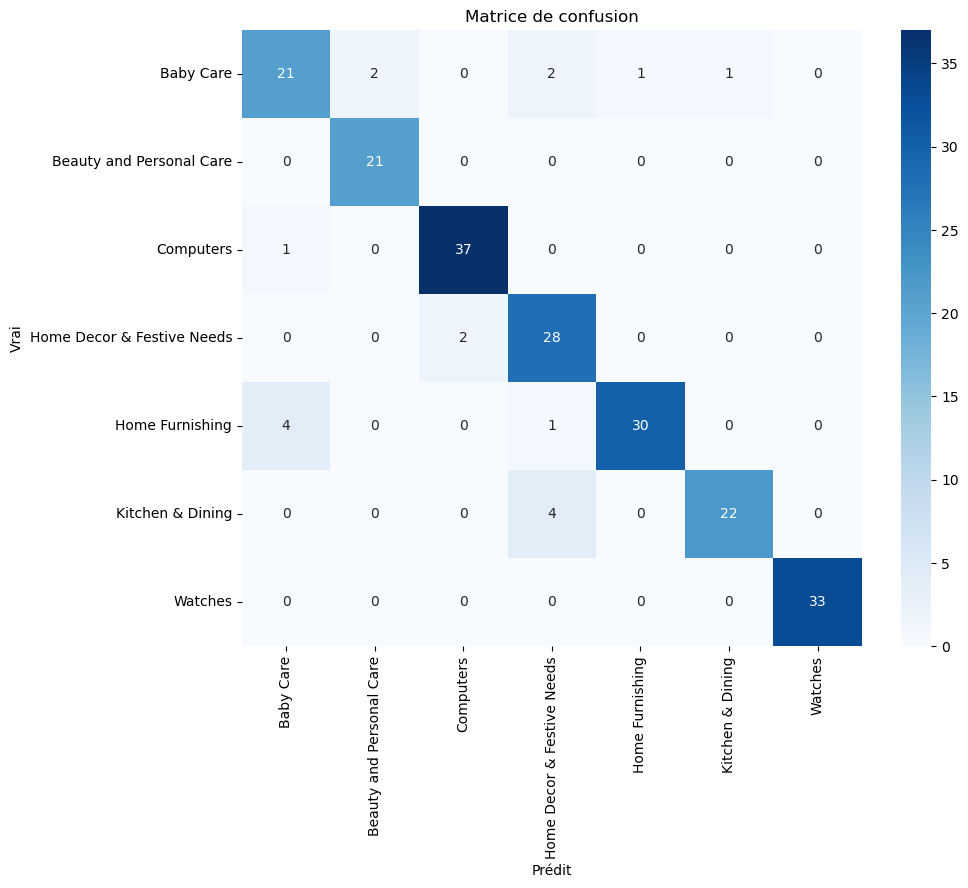

In [117]:
# Création d'une instance de RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Utilisation de la fonction perform_model_with_cross_validation avec le modèle RandomForestClassifier
rf_accuracy_tfidf, rf_ari_score_tfidf, rf_recall_tfidf, rf_precision_tfidf, rf_f1_tfidf = perform_model_with_cross_validation(rf_model,
                                                                                                                              X_train,
                                                                                                                              y_train,
                                                                                                                              X_test,
                                                                                                                              y_test)

## Sur BERT

In [118]:
# Sur les données réduites (ACP)
X = reduced_bert

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM

Cross-Validation Scores:
fit_time: 0.0419 (± 0.0008)
score_time: 0.0163 (± 0.0004)
test_Accuracy: 0.8702 (± 0.0197)
test_Adjusted Rand Score: 0.7247 (± 0.0356)
test_Recall: 0.8702 (± 0.0197)
test_Precision: 0.8831 (± 0.0134)
test_F1 Score: 0.8708 (± 0.0196)

Test Set Metrics:
Accuracy: 0.9048
Adjusted Rand Score: 0.8008
Recall: 0.9048
Precision: 0.9198
F1 Score: 0.9060


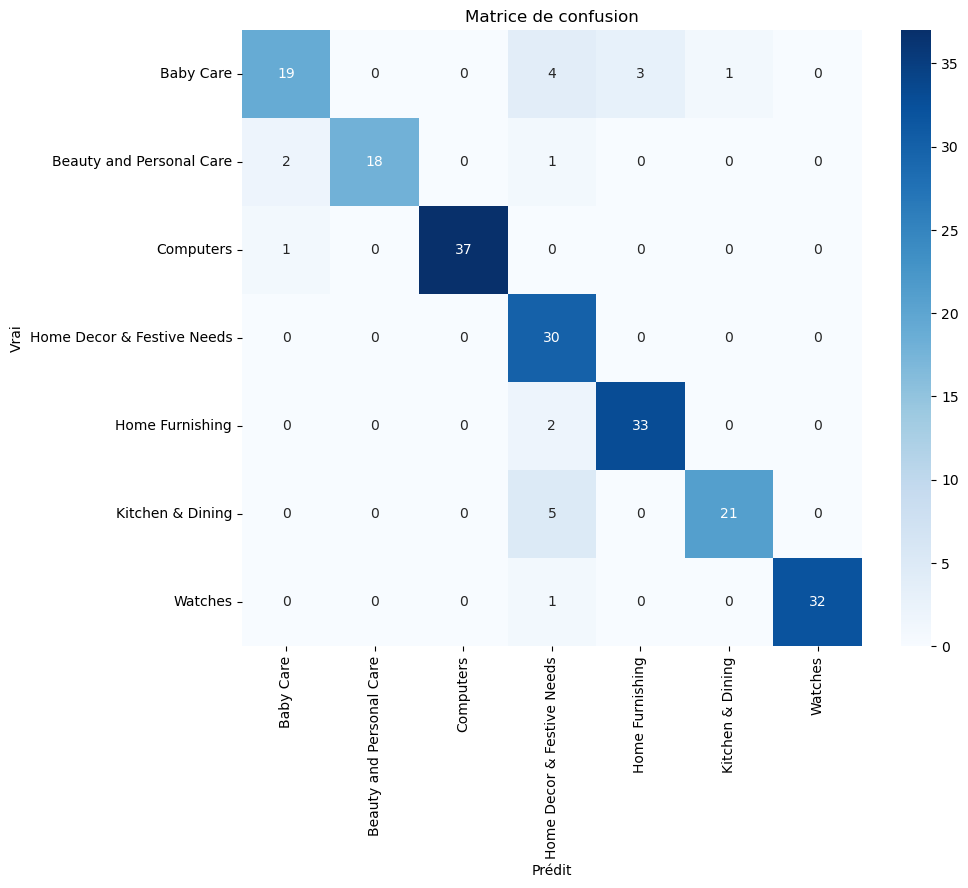

In [119]:
svm_model = SVC(random_state=42)
svm_accuracy_bert, svm_ari_score_bert, svm_recall_bert, svm_precision_bert, svm_f1_bert = perform_model_with_cross_validation(svm_model,
                                                                                                                              X_train,
                                                                                                                              y_train,
                                                                                                                              X_test,
                                                                                                                              y_test)

### Randorm Forest

Cross-Validation Scores:
fit_time: 0.8794 (± 0.0147)
score_time: 0.0132 (± 0.0004)
test_Accuracy: 0.8405 (± 0.0208)
test_Adjusted Rand Score: 0.6682 (± 0.0339)
test_Recall: 0.8405 (± 0.0208)
test_Precision: 0.8492 (± 0.0225)
test_F1 Score: 0.8405 (± 0.0213)

Test Set Metrics:
Accuracy: 0.8476
Adjusted Rand Score: 0.6950
Recall: 0.8476
Precision: 0.8634
F1 Score: 0.8463


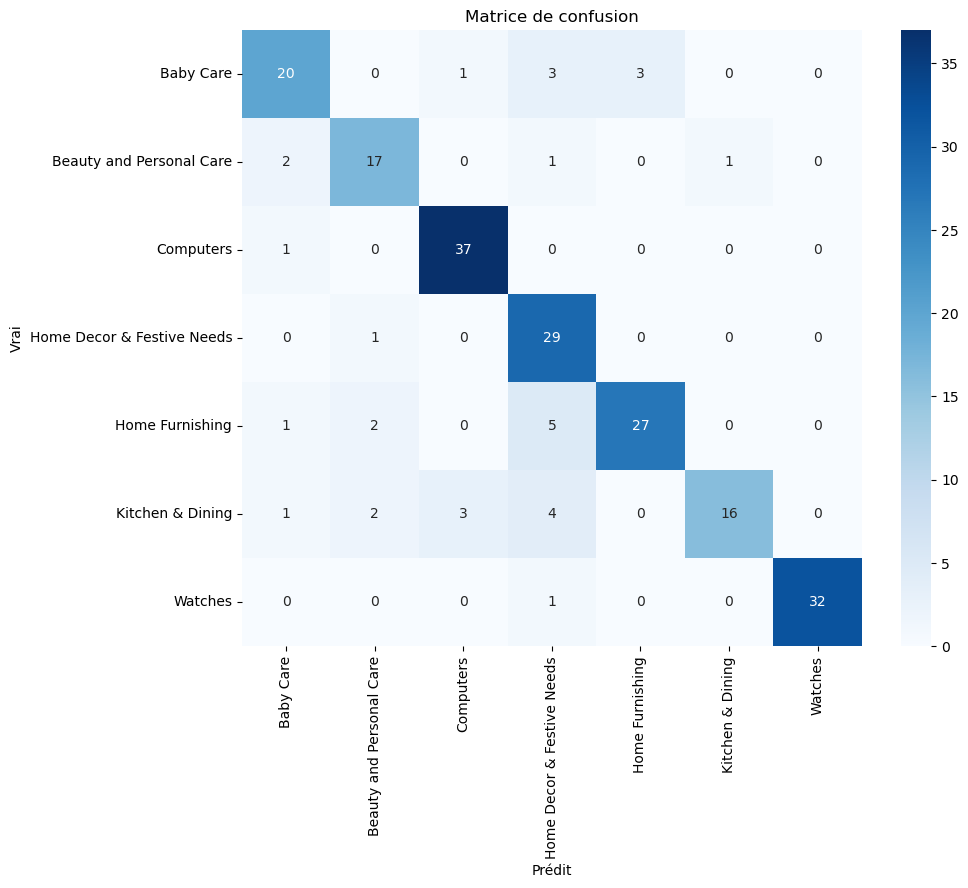

In [120]:
# Création d'une instance de RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Utilisation de la fonction perform_model_with_cross_validation avec le modèle RandomForestClassifier
rf_accuracy_bert, rf_ari_score_bert, rf_recall_bert, rf_precision_bert, rf_f1_bert = perform_model_with_cross_validation(rf_model,
                                                                                                                         X_train,
                                                                                                                         y_train,
                                                                                                                         X_test,
                                                                                                                         y_test)

## Sur USE

In [121]:
# Sur les données réduites (ACP)
X = reduced_use

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM

Cross-Validation Scores:
fit_time: 0.0312 (± 0.0021)
score_time: 0.0143 (± 0.0008)
test_Accuracy: 0.9333 (± 0.0170)
test_Adjusted Rand Score: 0.8504 (± 0.0367)
test_Recall: 0.9333 (± 0.0170)
test_Precision: 0.9383 (± 0.0142)
test_F1 Score: 0.9328 (± 0.0173)

Test Set Metrics:
Accuracy: 0.9429
Adjusted Rand Score: 0.8802
Recall: 0.9429
Precision: 0.9464
F1 Score: 0.9427


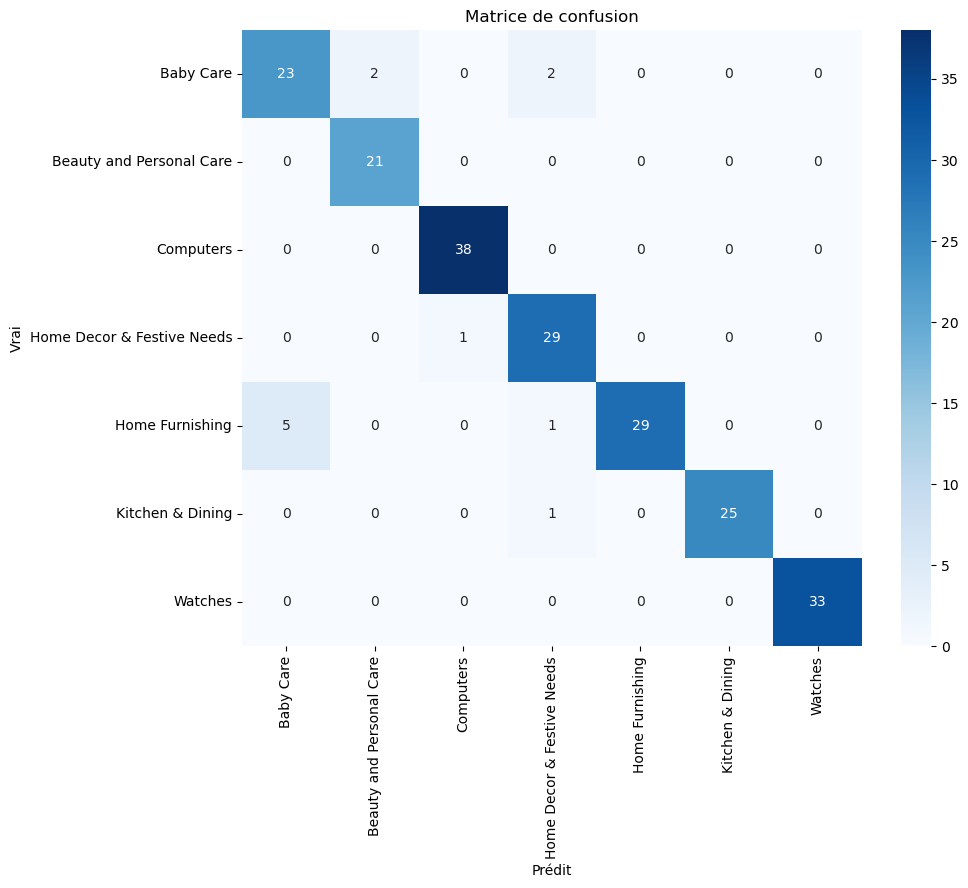

In [122]:
svm_model = SVC(random_state=42)
svm_accuracy_use, svm_ari_score_use, svm_recall_use, svm_precision_use, svm_f1_use = perform_model_with_cross_validation(svm_model,
                                                                                                                         X_train,
                                                                                                                         y_train,
                                                                                                                         X_test,
                                                                                                                         y_test)

### Random Forest

Cross-Validation Scores:
fit_time: 0.6636 (± 0.0117)
score_time: 0.0131 (± 0.0002)
test_Accuracy: 0.8940 (± 0.0102)
test_Adjusted Rand Score: 0.7739 (± 0.0223)
test_Recall: 0.8940 (± 0.0102)
test_Precision: 0.8977 (± 0.0096)
test_F1 Score: 0.8924 (± 0.0101)

Test Set Metrics:
Accuracy: 0.9095
Adjusted Rand Score: 0.8244
Recall: 0.9095
Precision: 0.9097
F1 Score: 0.9057


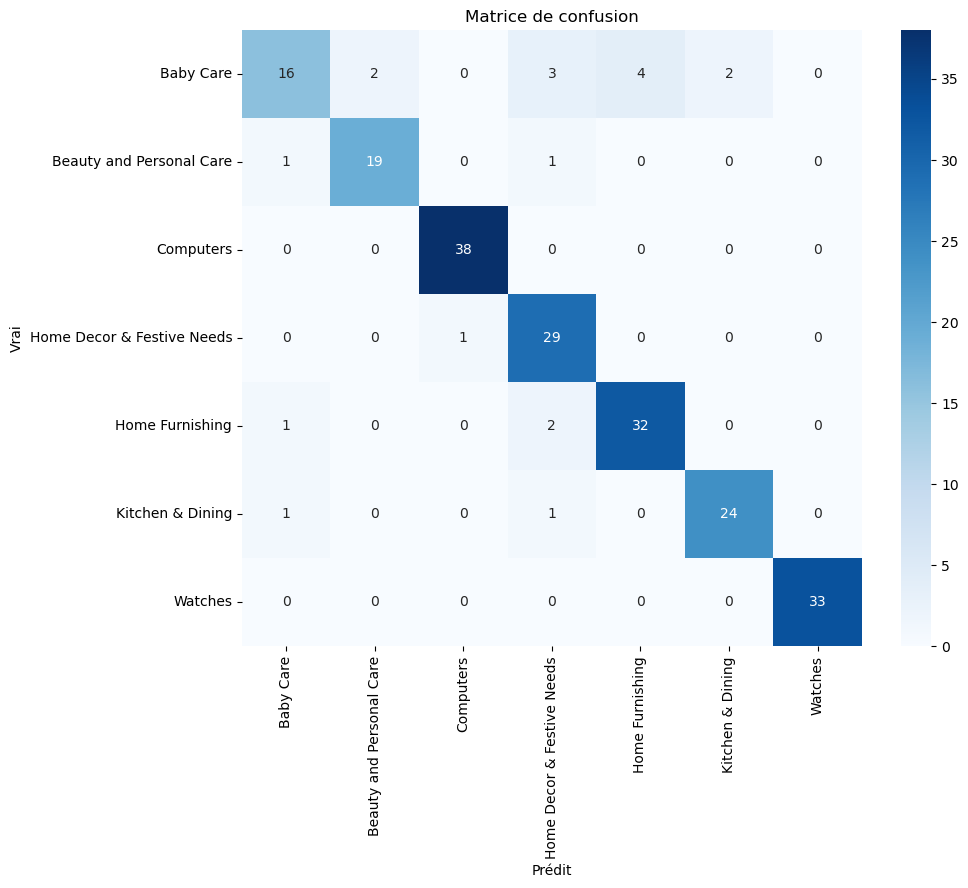

In [123]:
# Création d'une instance de RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Utilisation de la fonction perform_model_with_cross_validation avec le modèle RandomForestClassifier
rf_accuracy_use, rf_ari_score_use, rf_recall_use, rf_precision_use, rf_f1_use = perform_model_with_cross_validation(rf_model,
                                                                                                                    X_train,
                                                                                                                    y_train,
                                                                                                                    X_test,
                                                                                                                    y_test)